**PBS ADSORPTION STUDIES**

Rodrigo Toledo de Araujo \\
 Department of Electrical Engineering and Computation \\
 University of Campina Grande \\
 Campina Grande, Paraíba, Brazil

 rodrigo.araujo@ee.ufcg.edu.br

# **0. Molecular Analysis and Dilution**

Molarity ($M$) is defined as the number of moles of solute ($n$) per liter of solution ($V$).

\begin{equation}
M = \frac{n}{V}
\end{equation}

The relationship between moles ($n$), mass ($m$), and molar mass ($M_m$), is shown in \autoref{eq:moles}.

\begin{equation}
n = \frac{m}{M_m}
\end{equation}

\autoref{eq: mass} is typically used to find the required mass ($m$) for the proposed molarity (Combining \autoref{eq:molarity} and \autoref{eq:moles}).

\begin{equation}
m = M \times V \times M_m
\end{equation}

As in the NaOH experiment, the different concentrations of NaOH were produced by making a dilution of one bigger concentration (See \autoref{eq:dilution} for more details).

\begin{equation}
    C_{\text{new}}V_{\text{new}} = C_{\text{initial}}V_{\text{initial}}
\end{equation}

The typical formulation for 1 L of PBS-1x includes:

* 137 mM NaCl, 2.7 mM KCl, 10 mM Na$_2$HPO$_4$, 1.8 mM KH$_2$PO$_4$


1. Sodium Chloride (NaCl)
\begin{equation}
\text{Mass required} = 0.137 \, \text{mol/L} \times 58.44 \, \text{g/mol} = 7.998 \, \text{g}
\end{equation}

2. Potassium Chloride (KCl)
\begin{equation}
\text{Mass required} = 0.0027 \, \text{mol/L} \times 74.55 \, \text{g/mol} = 0.201 \, \text{g}
\end{equation}

3. Disodium Phosphate (Na$_2$HPO$_4$)
\begin{equation}
\text{Mass required} = 0.01 \, \text{mol/L} \times 141.96 \, \text{g/mol} = 1.42 \, \text{g}
\end{equation}

4. Monopotassium Phosphate (KH$_2$PO$_4$)
\begin{equation}
\text{Mass required} = 0.0018 \, \text{mol/L} \times 136.09 \, \text{g/mol} = 0.245 \, \text{g}
\end{equation}

By following a similar procedure, the molarity and mass for PBS-5x and PBS-10x it is presented in Table.

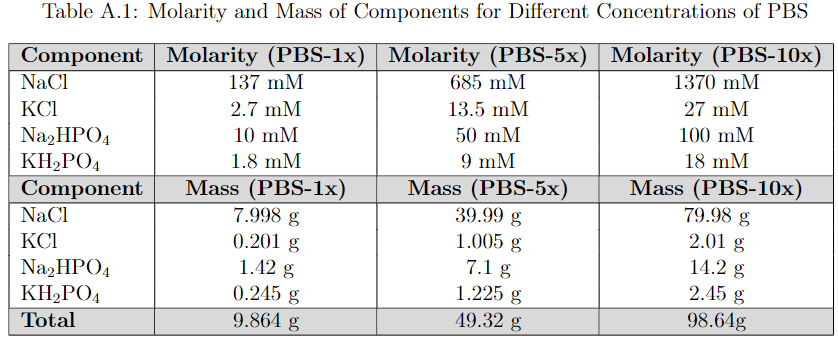

# 1. Importing Libraries

In [1]:
# Importing Libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import pandas as pd
from scipy.optimize import minimize
from cycler import cycler
import re
import jax
import jax.numpy as jnp
import jax.random as jrandom
import equinox as eqx
import optax
from typing import Callable, List
import subprocess
from scipy.integrate import solve_ivp
#from control.matlab import *
#import slycot
from scipy import signal,io
import os
from scipy.linalg import fractional_matrix_power


In [2]:
# Testing the backend
# Comando para obter informações sobre a GPU usando nvidia-smi
command = "nvidia-smi --query-gpu=name,memory.total --format=csv,noheader,nounits"
# Execute o comando e capture a saída
output = subprocess.check_output(command, shell=True, encoding="utf-8")
# Separe as linhas da saída
lines = output.strip().split("\n")
# imprima as informações da saída
for idx, line in enumerate(lines):
    name, memory = line.strip().split(",")
    print(f"GPU {idx} - Nome: {name}, Memória Total: {memory} MB")
    print(f"Jax backend:{jax.default_backend()}")
jax.devices()

GPU 0 - Nome: NVIDIA GeForce RTX 4060 Laptop GPU, Memória Total:  8188 MB
Jax backend:cpu


[CpuDevice(id=0)]

In [3]:
# Use LaTeX for text rendering
# Define a more scientific color cycle
scientific_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.rcParams.update({
    "text.usetex": True,
    "axes.labelsize": 12,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    'axes.prop_cycle':cycler(color=scientific_colors)
})

# write me a python code to plot a sine function


# 2. Fitting the PBS data into the Langmuir Model

## 1.1 Theory

In 1932, Langmuir developed the Langmuir adsorption isotherm, which describes the adsorption and desorption of molecules on a surface \cite{langmuir1932vapor}.

Following the principles of physical chemistry for reaction kinetics and thermodynamics the change in the amount of solute adsorbed on a surface per unit area over time can be expressed in the following equation \cite{latour2015langmuir}.



$$\frac{dq}{dt} = k_aC(Q-q)-k_dq$$


where $C$ is the solution concentration, $Q$ is the amount of solute adsorbed when all of the biding sites are filled, $q$ is the amount of solute adsorbed on the surface given a solution concentration $C$, $t$ is the time and $(Q-q)$ is the number of vacant sites for adsorption.

Under dynamic equilibrium conditions, $dq/dt=0$, the equilibrium constant and $q$ are given by:

$$K_A=\frac{k_a}{k_d} = \frac{q}{C(Q-q)}$$

$$q =\frac{QC}{C+K_A^{-1}}$$

The following equation is used  to quantify adsorption coverage (i.e. normalized coverage $0<\Theta<1$).

$$\Theta = \frac{\text{Occupied region}}{\text{Total available region}} = \frac{q}{Q}=\frac{V_a}{V_m} = \frac{m_a}{m_m}$$

where $\Theta $ represents the coverage of the surface, $ V_a $ is the volume of the adsorbate adhered, $ V_m $ is the maximum volume of adsorbate in a monolayer, $ m_a $ is the number of moles adhered, and $ m_m $ is the maximum number of moles of adsorbate in a monolayer.

Then, the first order differential equation (i.e. Langmuir isotherm) in terms of the normalized coverage is:

$$\frac{d(q/Q)}{dt}=\frac{d\Theta}{dt} = k_aC(1-\Theta)-k_d\Theta$$

And has exponential solutions (i.e. $\Theta(t)$) given by:

   $$ \Theta(t) = \left(\frac{k_aC}{k_aC+k_d}\right)\left(1-e^{-({k_aC+k_d})t}\right), \quad \text{or}\quad
\Theta(t) = \left(\frac{C}{C+K_A^{-1}}\right)\left(1-e^{-({k_aC+k_d})t}\right)$$

The molecular surface under steady state conditions, from the previous equation is given by:

$$\Theta^\infty=\lim_{t\rightarrow\infty}\Theta(t)=\frac{C}{C+K_A^{-1}}$$




## 1.2 Applying the model to the PBS (Find the kinetic constants)

### A. Theory

The effective refractive index variation $\Delta \mathcal{N}_s^{\text{eff}}$ can be estimated by using the surface coverage (i.e., $\Theta_{\text{mol}}(C_s)$, derived from one of the adsorption models) as shown in the following equation:

$$\Delta \mathcal{N}_s^{\text{eff}}(C_s) = \Delta \mathcal{N}_{\text{mol}}^{\text{max}}\Theta_{\text{mol}}(C_s)$$

Being:

$$\Theta_{\text{mol}}(C)=\frac{C}{C+K_A^{-1}}\theta_\infty$$

Then:

$$\Delta \mathcal{N}_s^{\text{eff}} = \Delta \mathcal{N}_{\text{mol}}^{\text{max}}\frac{C}{C+K_A^{-1}}\theta_{\infty} \longrightarrow\Delta \mathcal{N}_s^{\text{eff}}K_A^{-1}-\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty} C=-C\Delta \mathcal{N}_s^{\text{eff}}$$

Using the information of two points: ($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$), a linear set of equations can be derived (In the matrix form):

$$
  \begin{bmatrix}
\Delta \mathcal{N}_{s1}^{\text{eff}} & -C_1\\
\Delta \mathcal{N}_{s2}^{\text{eff}} & -C_2
\end{bmatrix}\begin{bmatrix}
K_A^{-1}\\
\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty}
\end{bmatrix}=\begin{bmatrix}
-C_1\Delta \mathcal{N}_{s1}^{\text{eff}}\\
-C_2\Delta \mathcal{N}_{s2}^{\text{eff}}
\end{bmatrix}  
$$

Where:

* $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$, $\theta_{\infty}$  and $K_A^{-1}$ are the constant unknowns
* $C$ and $\Delta \mathcal{N}_s^{\text{eff}}$ are the coefficients (we already know their values) that vary.

Given that the values of the two points [($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$)] are known, by using a numerical method (e.g., Gauss method), the unknown variables are quickly defined.

### B. Importing data and visualization

In [4]:
# Step 2: Define the directory containing the Excel files
#dir_path = r"/home/toledorodrigo/Curvas_PBS - Copy"
dir_path = 'G:\My Drive\Colab Notebooks\Biosensors\Data\Curvas_PBS - Copy'
# Step 3: Initialize an empty dictionary to store data'
data_dict = {}

# Step 4: List all files in the directory
file_list = os.listdir(dir_path)

# Step 5: Sort files numerically based on the number in the file name
def extract_number(file_name):
    match = re.search(r'\d+', file_name)
    return int(match.group()) if match else float('inf')

file_list = sorted(file_list, key=extract_number)

# Step 6: Loop through the sorted files and read each Excel file into the dictionary
for file_name in file_list:
    if file_name.endswith('.csv'):
        file_path = os.path.join(dir_path, file_name)
        data_dict[file_name] = pd.read_csv(file_path,delimiter=';')

<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
C:\Users\rodri\AppData\Local\Temp\ipykernel_24524\1356380580.py:3: SyntaxWarning: invalid escape sequence '\M'
  dir_path = 'G:\My Drive\Colab Notebooks\Biosensors\Data\Curvas_PBS - Copy'


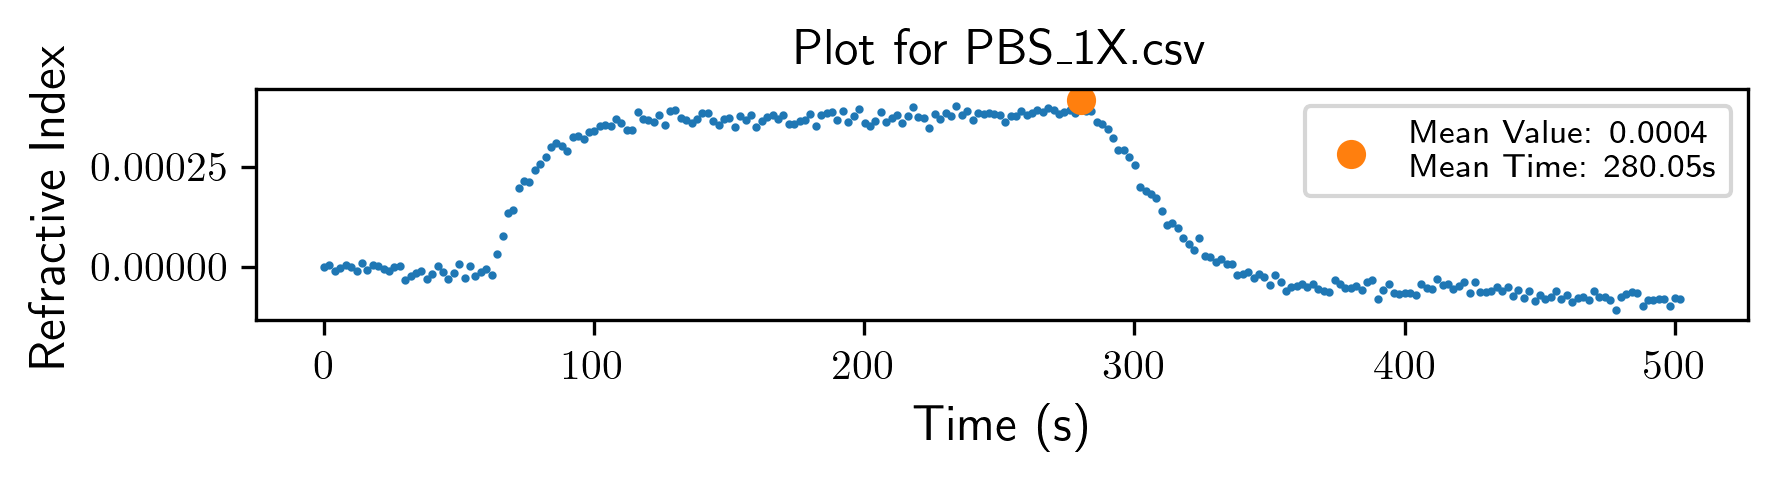

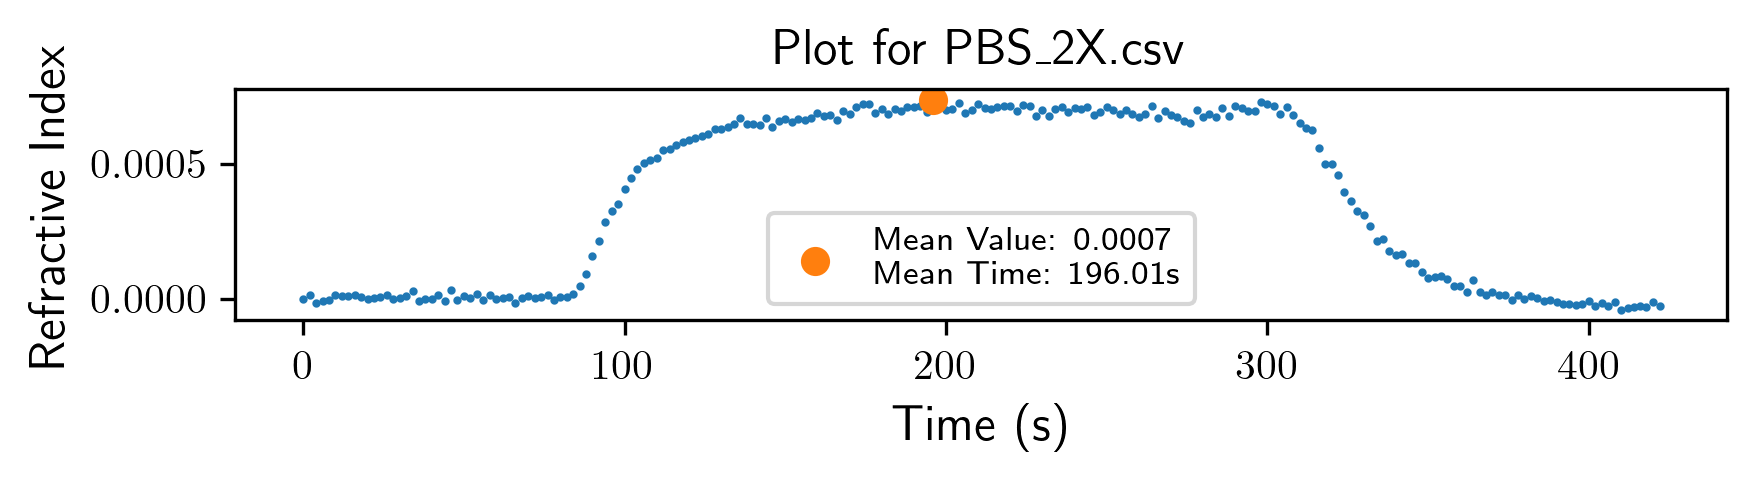

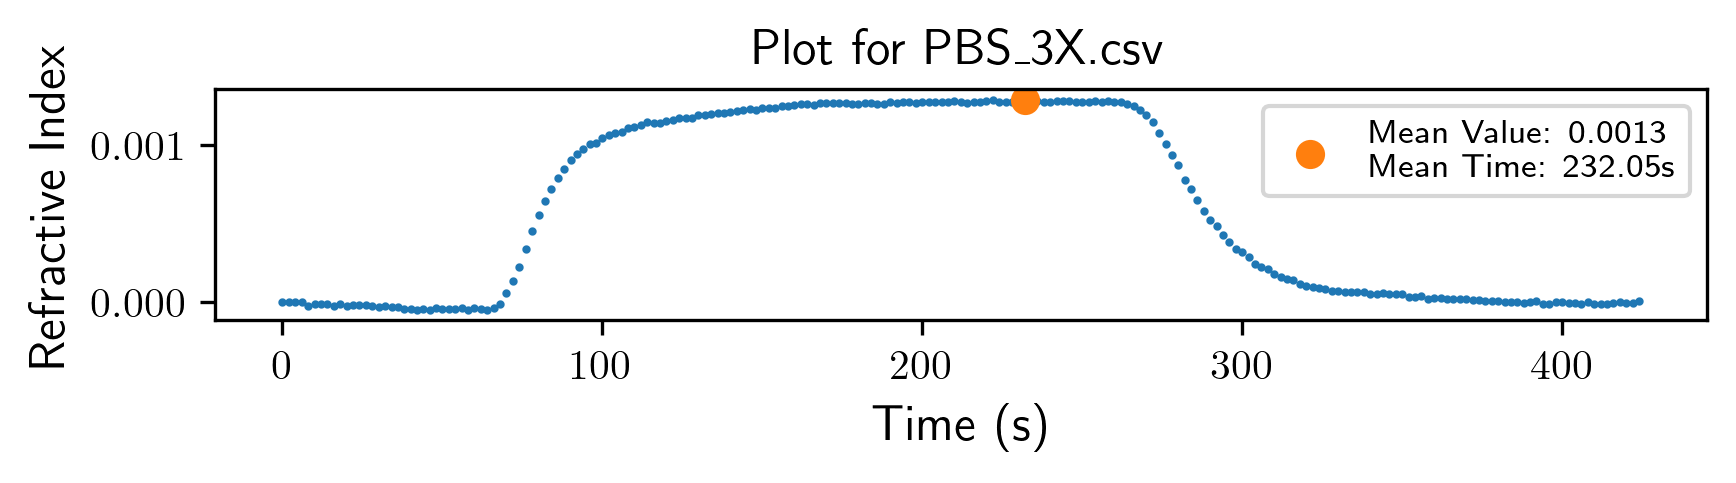

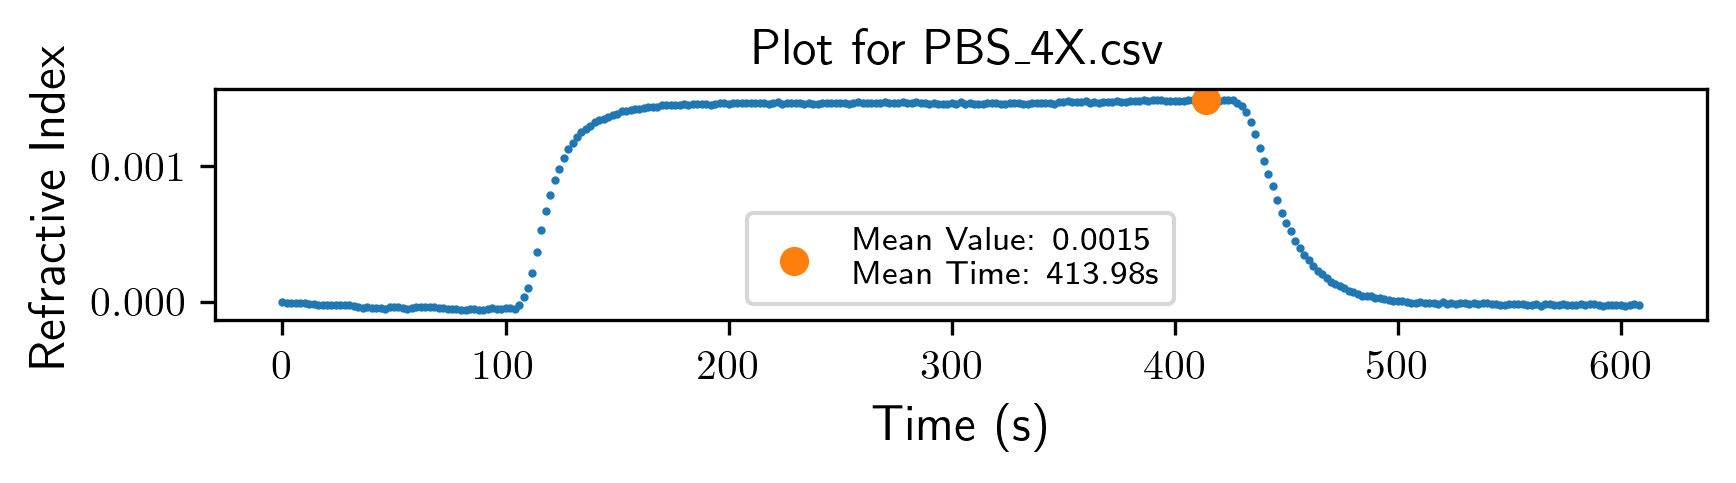

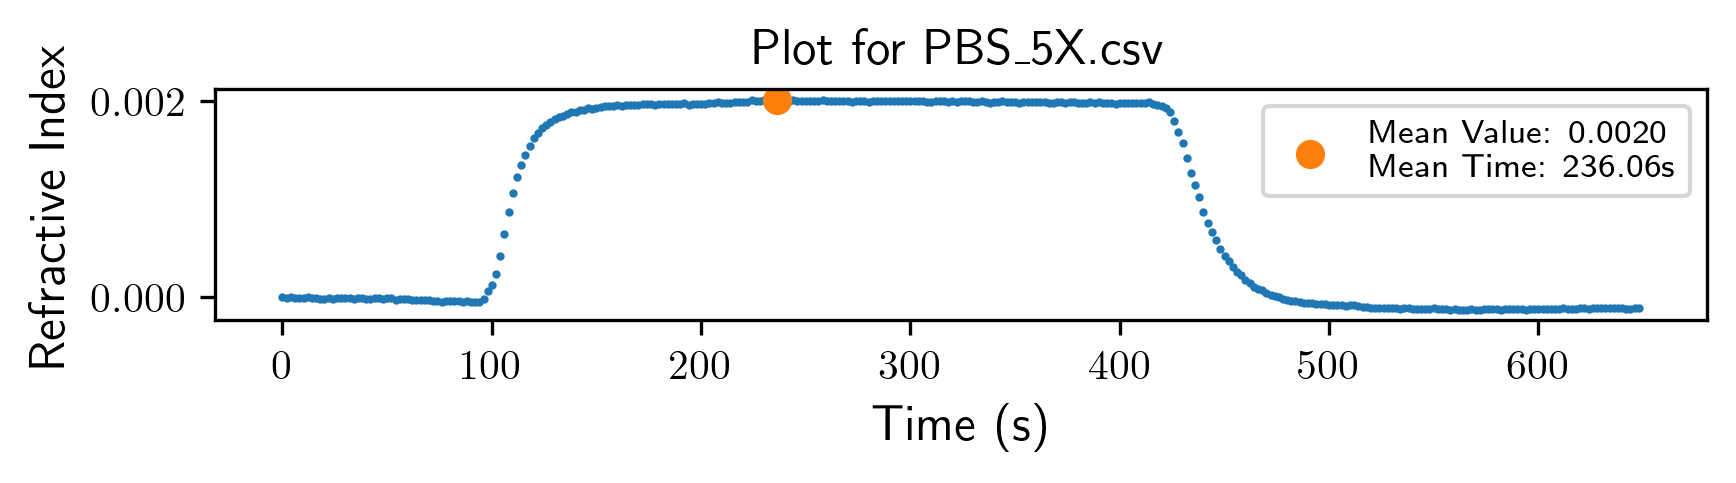

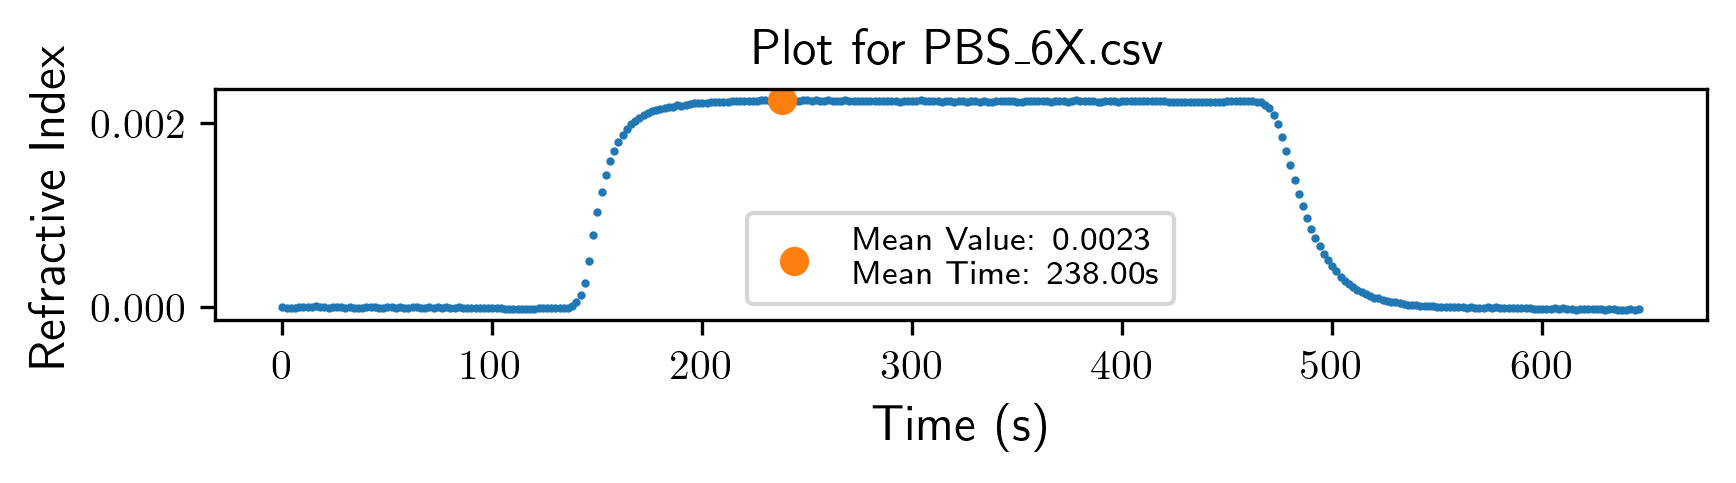

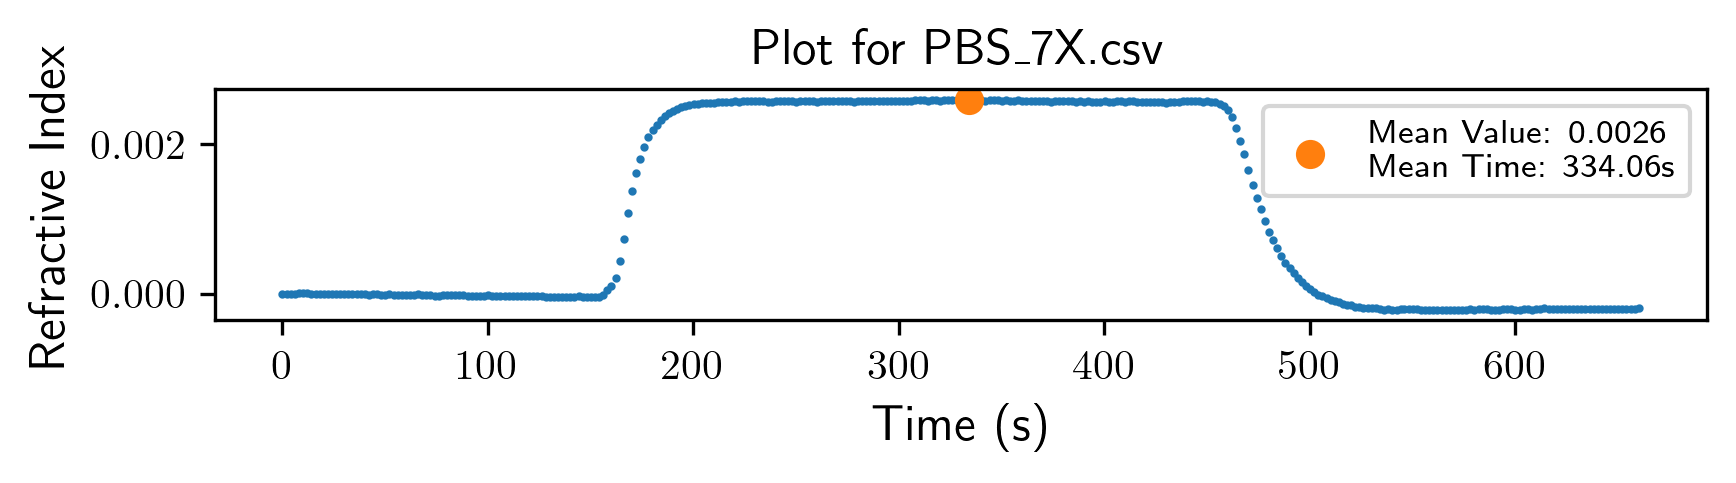

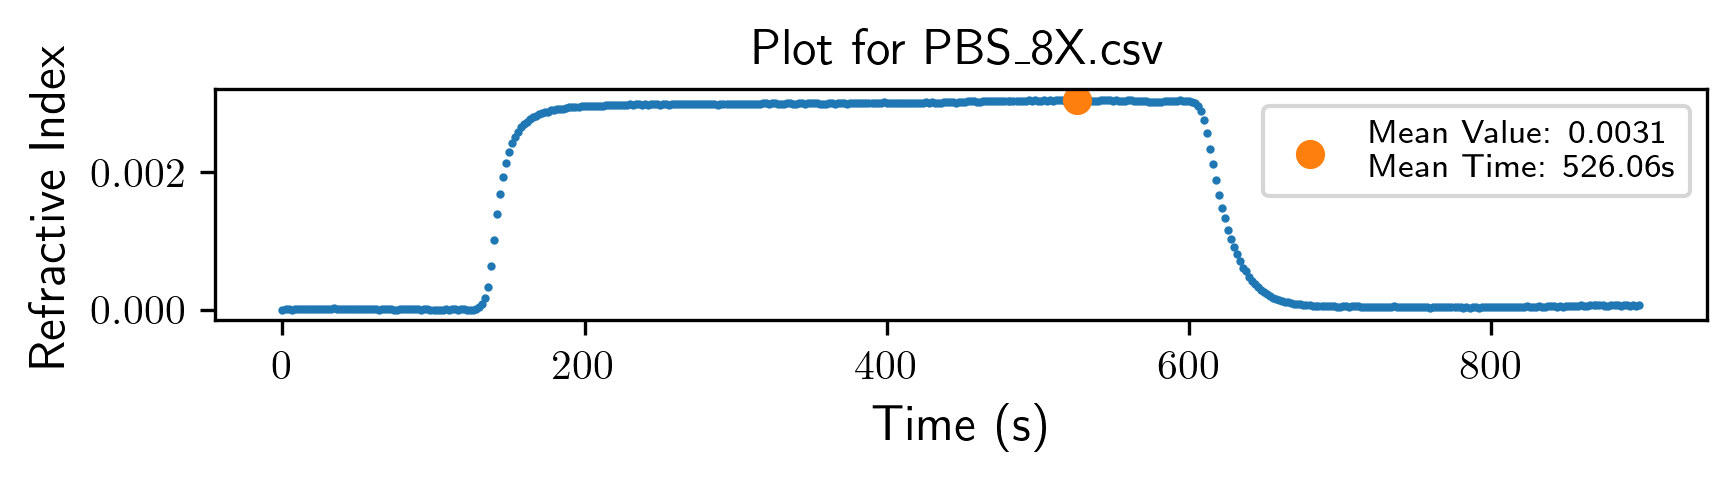

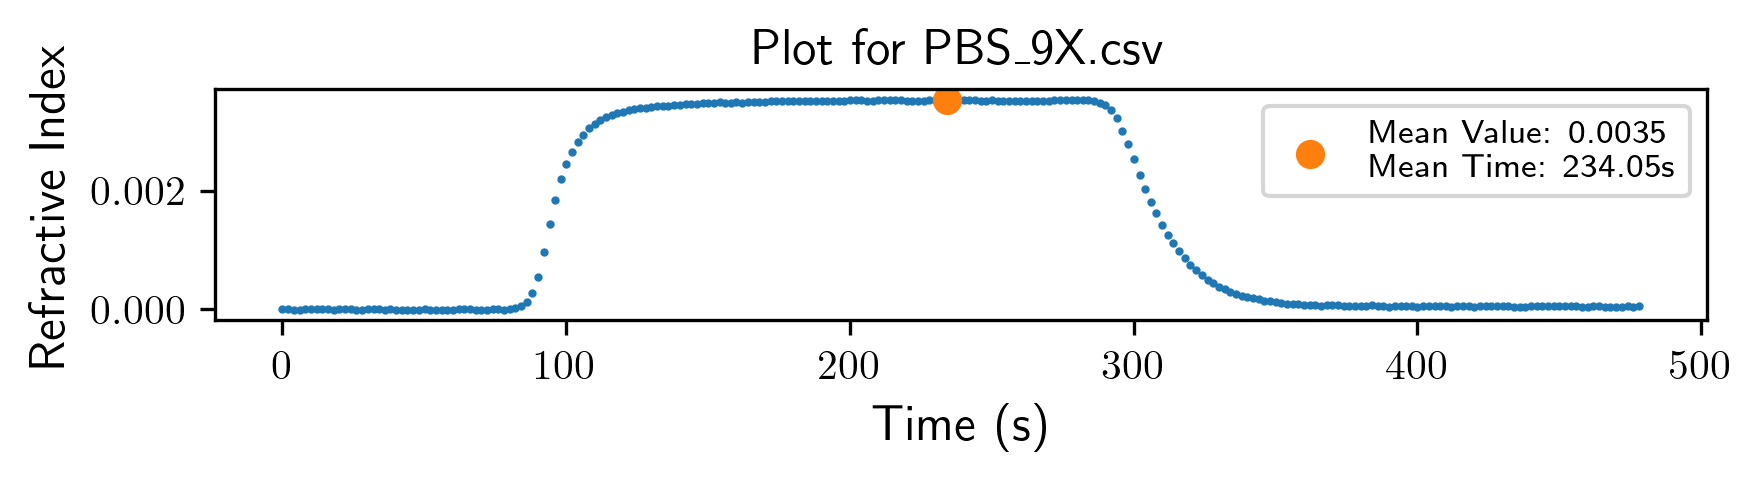

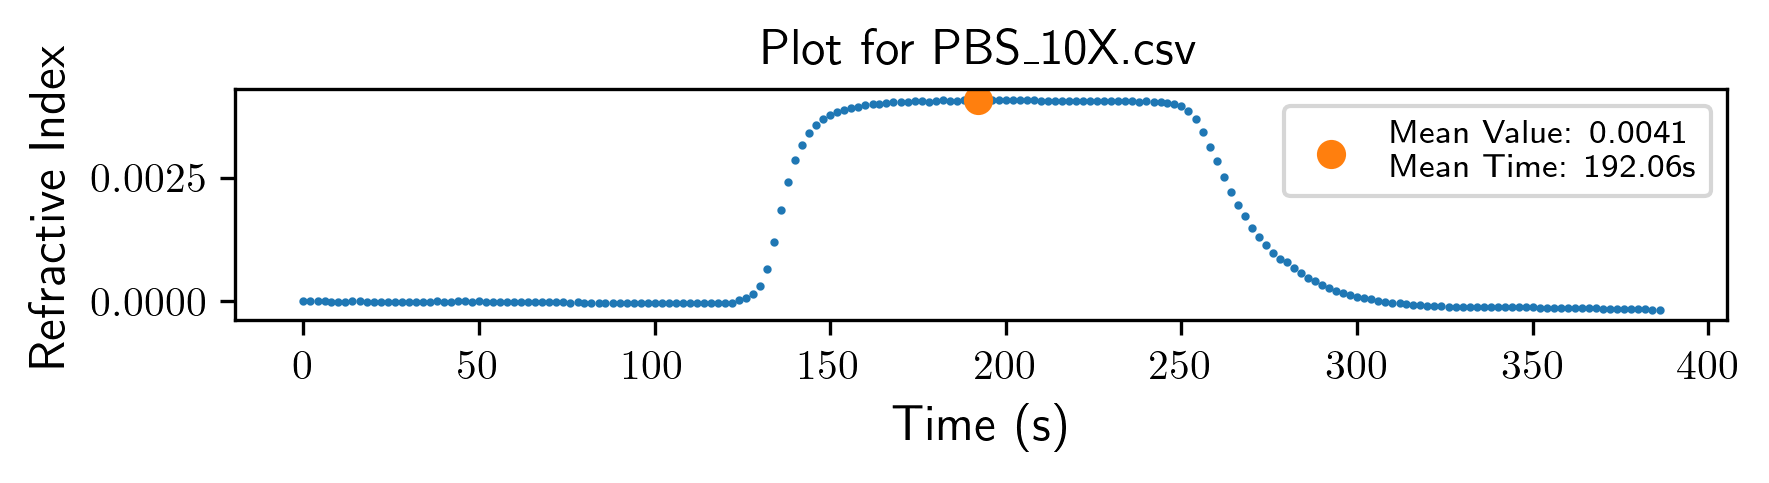

In [5]:
max_values_dict = {}
#concentration = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
#concentration = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
concentration = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01]
#concentration = [0.1515,2*0.1515,3*0.1515,4*0.1515,5*0.1515,6*0.1515,7*0.1515,8*0.1515,9*0.1515,10*0.1515]
window_size = 1  # Set this to the number of top values you want to average

for i, (file_name, data) in enumerate(data_dict.items()):
    # Getting the time and the refractive index
    time = data['Time']
    refrac_var = data[' Refractive Index']
    comments = data[' Comment']  # Adjust the column name as needed

    # Sort the refractive index and get the indices of the top 'window_size' values
    top_indices = refrac_var.nlargest(window_size).index
    
    # Get the mean of the top 'window_size' refractive index values and corresponding times
    mean_value = refrac_var.loc[top_indices].mean()
    mean_time = time.loc[top_indices].mean()

    # Store the mean values in the dictionary
    max_values_dict[file_name] = {
        'mean_value': mean_value, 
        'mean_time': mean_time,
        'concentration': concentration[i]  # Add the corresponding concentration
    }

    # Plotting the time versus refractive index
    fig, ax = plt.subplots(figsize=(6.417, 1), dpi=300)
    ax.scatter(time, refrac_var, s=1)
    ax.scatter(mean_time, mean_value, label=f'Mean Value: {mean_value:.4f}\nMean Time: {mean_time:.2f}s')
    ax.set_ylabel('Refractive Index')
    ax.set_xlabel('Time (s)')
    ax.legend(fontsize=8)

    # Annotate each point with the respective comment
    for t, r, c in zip(time, refrac_var, comments):
        if pd.notna(c):  # Only add text for non-NaN comments
            plt.text(t, r, str(c), fontsize=4, ha='right')

    # Add a title with the file name for reference
    ax.set_title(f'Plot for {file_name}')

    # Show the plot
    plt.show()


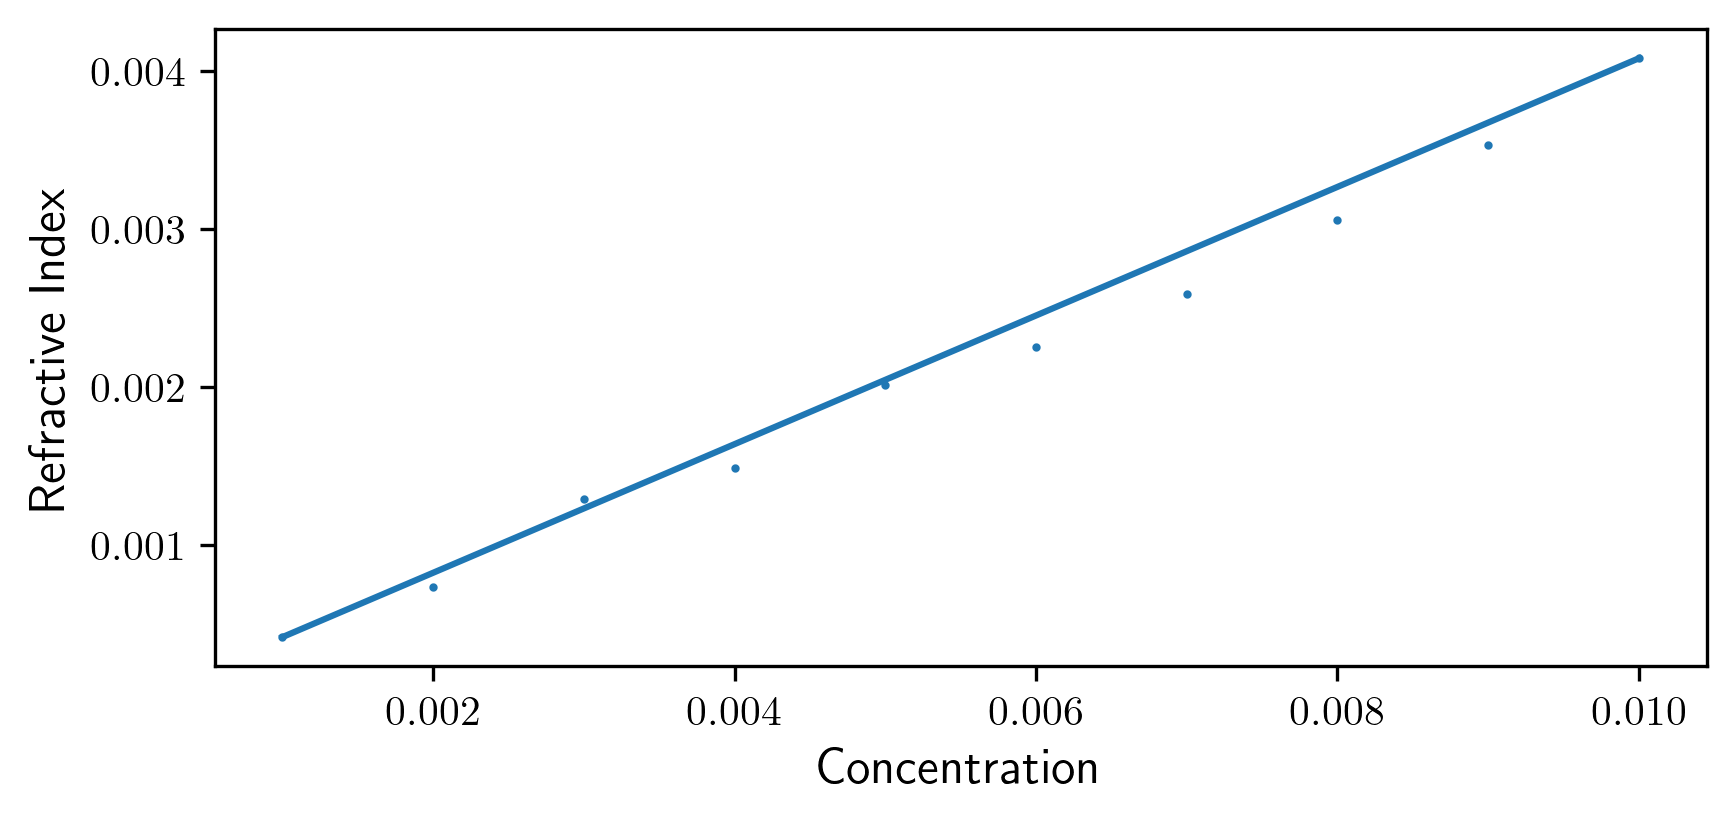

In [6]:
# Plotting the maximum value over the concentration
fig, ax = plt.subplots(figsize = (6.417,2.7559), dpi = 300)
ax.set_ylabel('Refractive Index')
ax.set_xlabel('Concentration')
max_values = []
for file_name, data in max_values_dict.items():
  max_values.append(data['mean_value'])
  ax.scatter(data['concentration'],data['mean_value'], s = 1,color = '#1f77b4')
  
C1 = max_values_dict['PBS_1X.csv']['concentration'];C2 = max_values_dict['PBS_10X.csv']['concentration']
R1 = max_values_dict['PBS_1X.csv']['mean_value'];R2 = max_values_dict['PBS_10X.csv']['mean_value']

ax.plot([C1,C2],[R1,R2])

In [7]:
# # Saving the figure
# fig.savefig('/content/drive/MyDrive/UFCG/Mestrado/Biosensors/MILKGOATADULTERATION/Plots/Cow_Goat_100_70_30_20_10_05_01.png', bbox_inches='tight')
# files.download('/content/drive/MyDrive/UFCG/Mestrado/Biosensors/MILKGOATADULTERATION/Plots/Cow_Goat_100_70_30_20_10_05_01.png')

### C. Finding $K_a$ and $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$

Using the information of two points: ($C_1$, $\Delta \mathcal{N}_{s1}^{\text{eff}}$) and ($C_2$, $\Delta \mathcal{N}_{s2}^{\text{eff}}$), a linear set of equations can be derived (In the matrix form):

$$
  \begin{bmatrix}
\Delta \mathcal{N}_{s1}^{\text{eff}} & -C_1\\
\Delta \mathcal{N}_{s2}^{\text{eff}} & -C_2
\end{bmatrix}\begin{bmatrix}
K_A^{-1}\\
\Delta \mathcal{N}_{\text{mol}}^{\text{max}}\theta_{\infty}
\end{bmatrix}=\begin{bmatrix}
-C_1\Delta \mathcal{N}_{s1}^{\text{eff}}\\
-C_2\Delta \mathcal{N}_{s2}^{\text{eff}}
\end{bmatrix}  
$$

In [8]:
C1 = max_values_dict['PBS_1X.csv']['concentration'];C2 = max_values_dict['PBS_10X.csv']['concentration']
R1 = max_values_dict['PBS_1X.csv']['mean_value'];R2 = max_values_dict['PBS_10X.csv']['mean_value']

In [9]:
A = np.array([[R1, -C1],[R2, -C2]])
B = np.array([-C1*R1, -C2*R2])
S = np.linalg.solve(A,B)
Ka = S[0]**(-1)
var_n_mol_thetainf = S[1]
Constants_1 = {
    'Ns1': [R1],
    'C1'   : [C1],
    'Ns2': [R2],
    'C2'   : [C2],
    'KA': [Ka],
    'Nmol'   : [var_n_mol_thetainf],
}

df_Constants_1 = pd.DataFrame(Constants_1)
df_Constants_1

,Ns1,C1,Ns2,C2,KA,Nmol
0,0.000418,0.001,0.004078,0.01,2.712715,0.154418


### D. Finding $\Delta \mathcal{N}_{\text{mol}}^{\text{max}}$ and $\theta_{\infty}$

In [10]:
def fit_thermodynamic_parameters(N_eff_exp, Ka, C_exp, initial_guess):
    def model(params):
        N_mol_max, Theta_inft = params
        N_eff = (N_mol_max*Theta_inft*C_exp / (C_exp+(1/Ka)))
        return N_eff

    def objective_function(params):
        N_eff_model = model(params)
        MSE = np.mean((N_eff_model - N_eff_exp) ** 2)
        return MSE

    # Define the constraint N_mol_max*Theta_inft = 0.402483
    def constraint(params):
        N_mol_max, Theta_inft = params
        return N_mol_max*Theta_inft - var_n_mol_thetainf

    # Initial guess
    N_mol_max_initial, Theta_inft_initial = initial_guess

    # Constraints dictionary for scipy.optimize.minimize
    constraints = {'type': 'eq', 'fun': constraint}

    # Perform the optimization
    result = minimize(objective_function, [N_mol_max_initial, Theta_inft_initial], method='SLSQP', constraints=constraints)

    # Extract the optimized parameters
    N_mol_max_opt, Theta_inft_opt = result.x
    mse = result.fun

    return N_mol_max_opt, Theta_inft_opt, mse

In [11]:
# Initial guesses for ka and kd
C_values = np.array(concentration);
initial_guess = [0.1,1]
N_mol_max_opt, Theta_inft_opt, mse = fit_thermodynamic_parameters(max_values,Ka,C_values,initial_guess)

In [12]:
fitvalues = {
             'MSE': [mse],
             'N_mol_max_opt': [N_mol_max_opt],
             'Theta_inft_opt': [Theta_inft_opt],
}
pd.DataFrame(fitvalues)

,MSE,N_mol_max_opt,Theta_inft_opt
0,2.513016e-08,0.153598,1.005345


#### 1.3.1.2 Making the isotherm plot

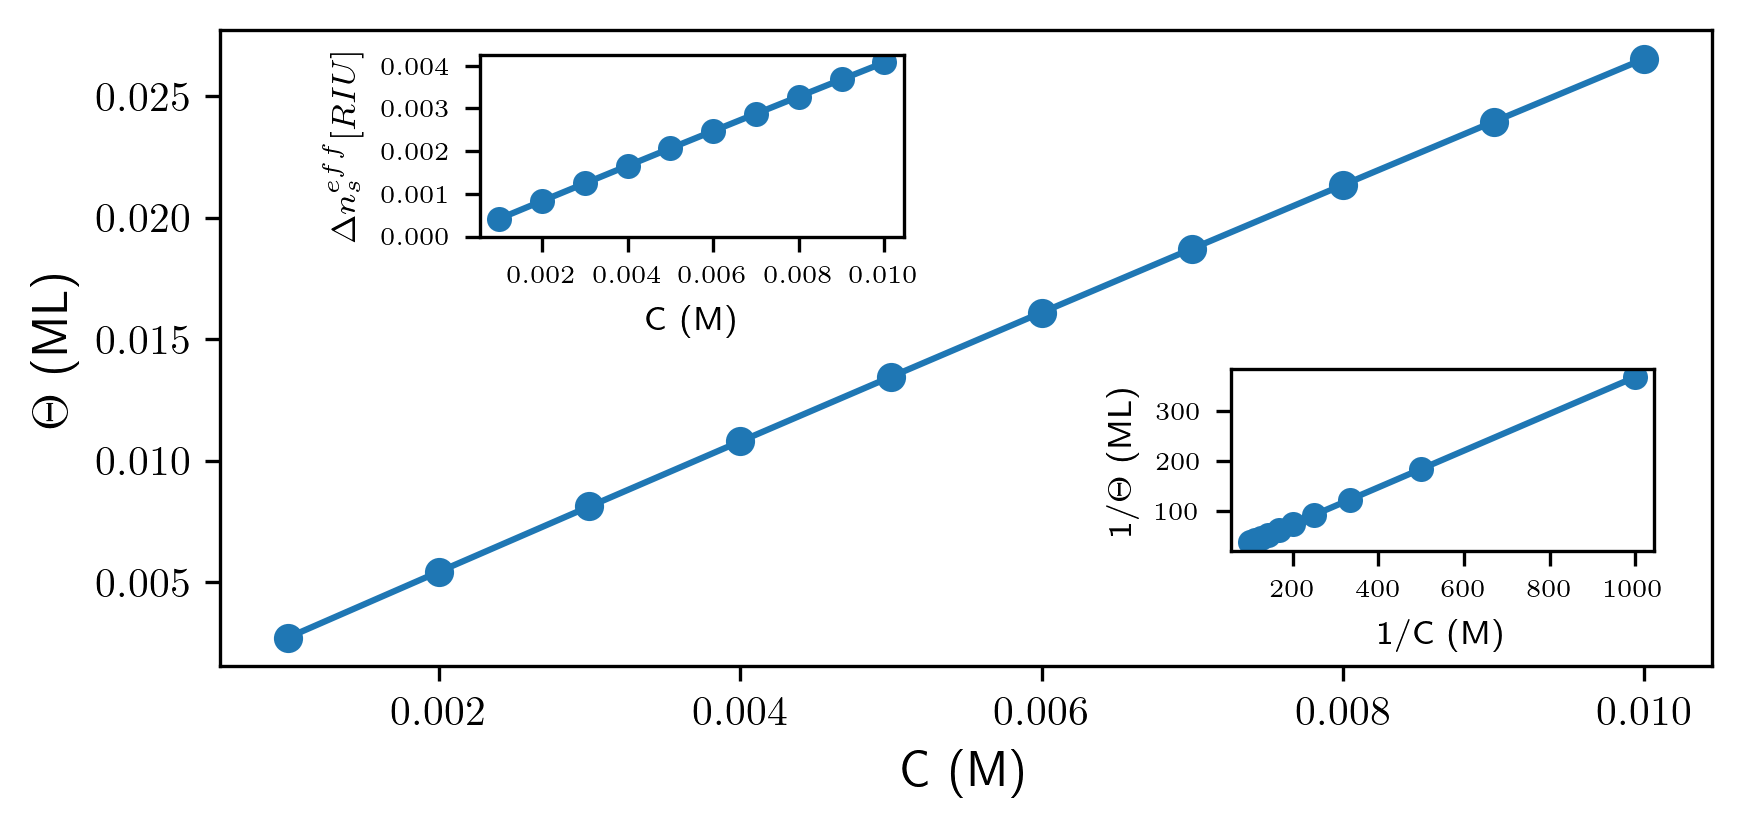

In [13]:
# Plotting the data
C = C_values
Theta_c = Ka*C/(1+Ka*C)*Theta_inft_opt
fig, ax = plt.subplots(figsize = (6.417,2.7559), dpi = 300)
ax.scatter(C,Theta_c, label=r'Estimated points')
ax.plot(C,Theta_c,label='Linear Interpolation')
ax.set_xlabel('C (M)')
ax.set_ylabel(r'$\Theta$ (ML)')
ax.grid(visible=False)
#ax.legend()
inner_ax = fig.add_axes([0.65, 0.25, 0.22, 0.22]) # [left, bottom, width, height]

# Plot the inverse

inner_ax.scatter(1/C,1/Theta_c,linewidths=0.01)
inner_ax.plot(1/C,1/Theta_c)
inner_ax.grid(visible=False)
inner_ax.set_xlabel('1/C (M)',fontsize=8)
inner_ax.set_ylabel(r'1/$\Theta$ (ML)',fontsize=8)
# Adjust the tick label sizes
inner_ax.tick_params(axis='x', labelsize=6)
inner_ax.tick_params(axis='y', labelsize=6)
#inner_ax.set_yticks([0,1e-3,2e-3,3e-3,4e-3])

inner_ax2 = fig.add_axes([0.26, 0.63, 0.22, 0.22]) # [left, bottom, width, height]

# Plot the inverse

inner_ax2.scatter(C,Theta_c*N_mol_max_opt,linewidths=0.01)
inner_ax2.plot(C,Theta_c*N_mol_max_opt)
inner_ax2.set_yticks([0,1e-3,2e-3,3e-3,4e-3])
inner_ax2.grid(visible=False)
inner_ax2.set_xlabel(r'C (M)',fontsize=8)
inner_ax2.set_ylabel(r'$\Delta n_s^{eff} [RIU]$',fontsize=8)
# Adjust the tick label sizes
inner_ax2.tick_params(axis='x', labelsize=6)
inner_ax2.tick_params(axis='y', labelsize=6)

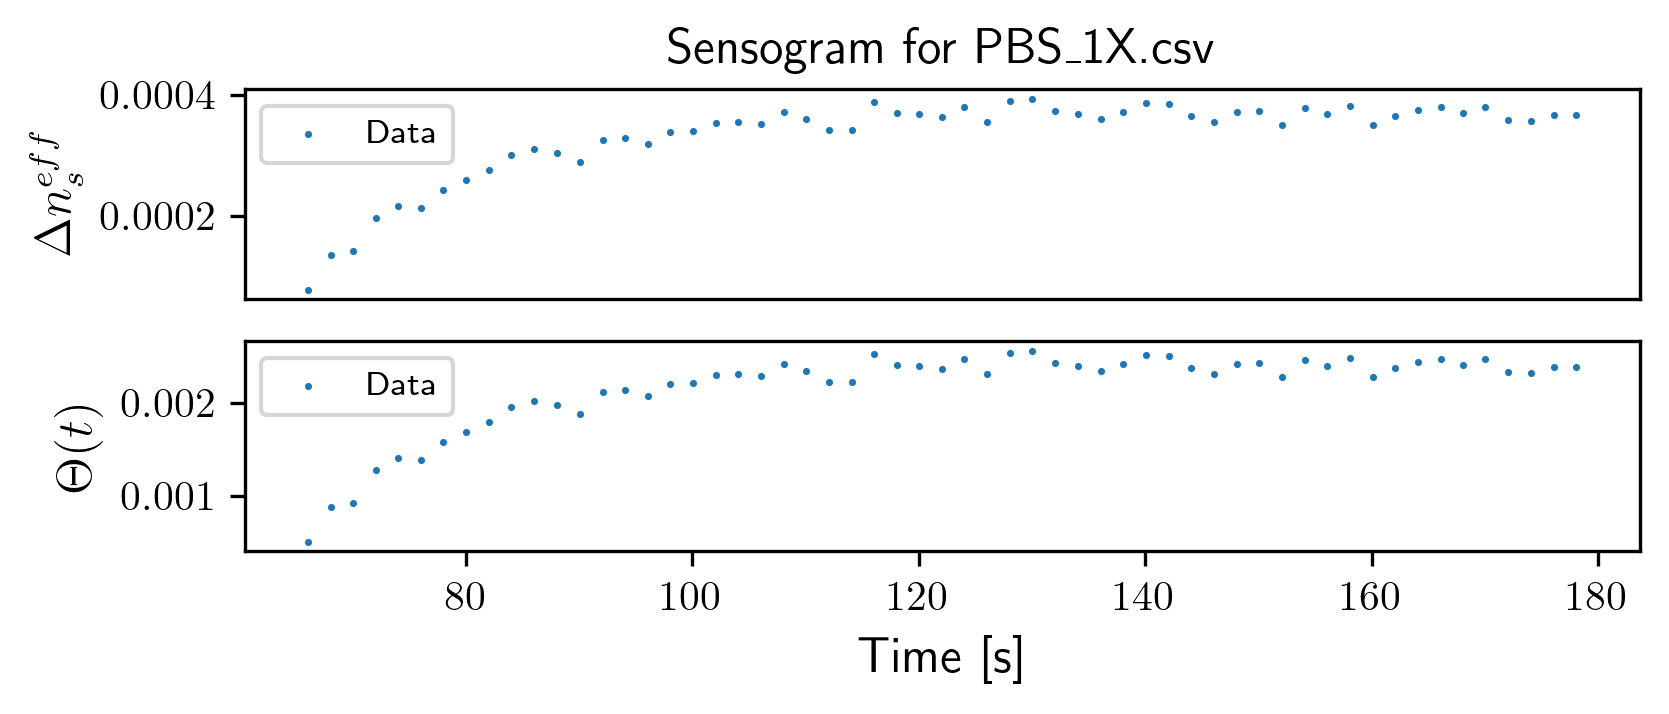

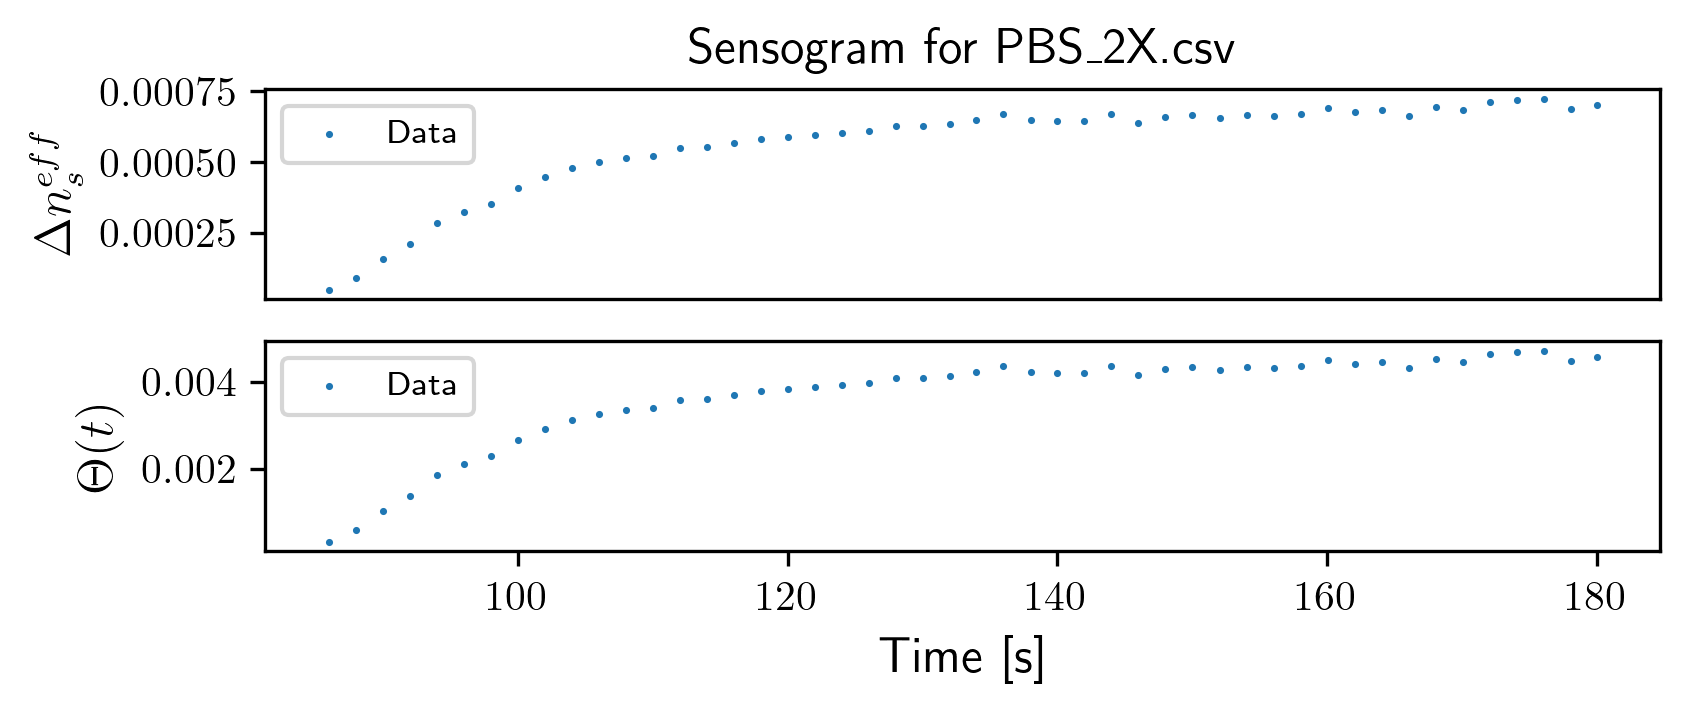

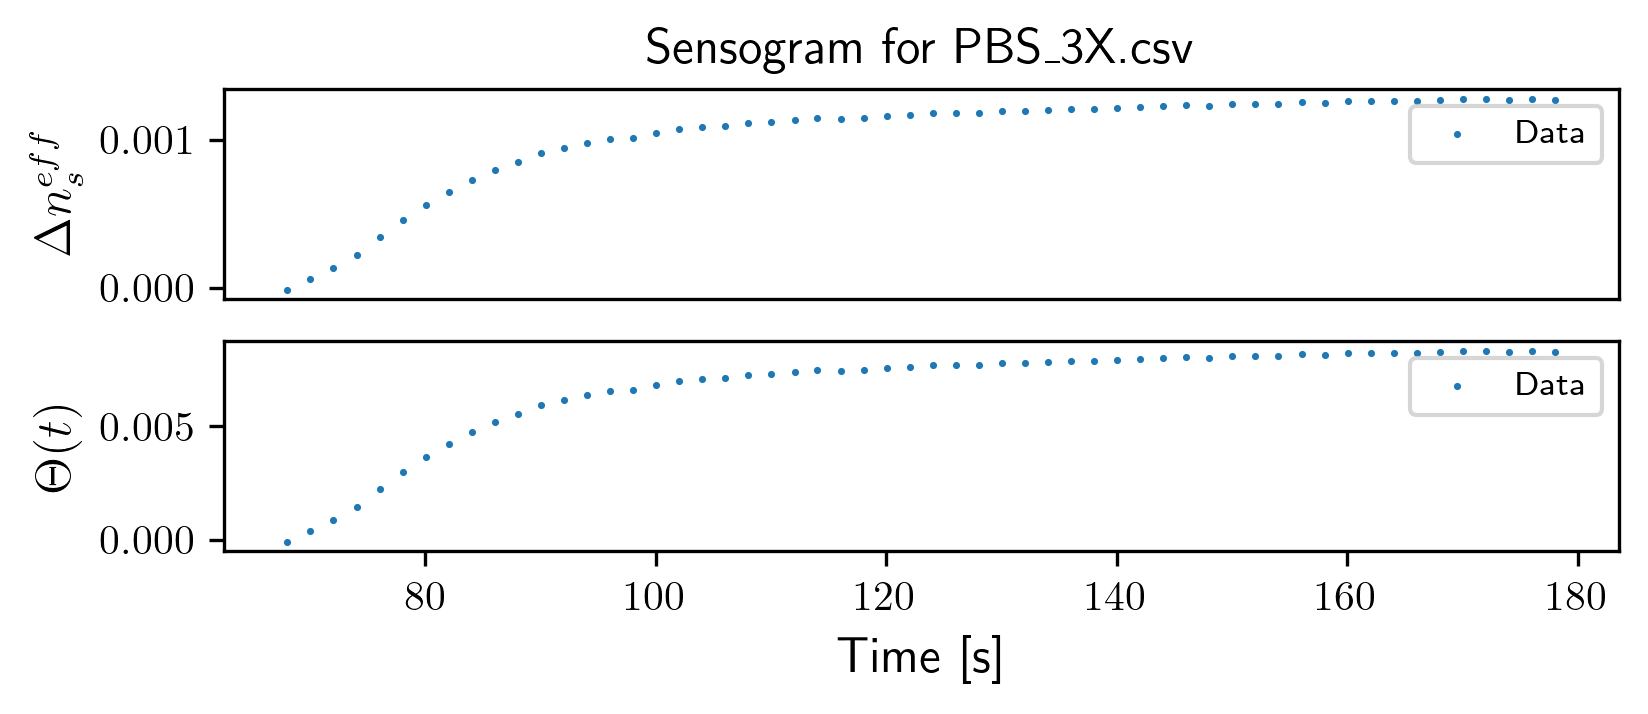

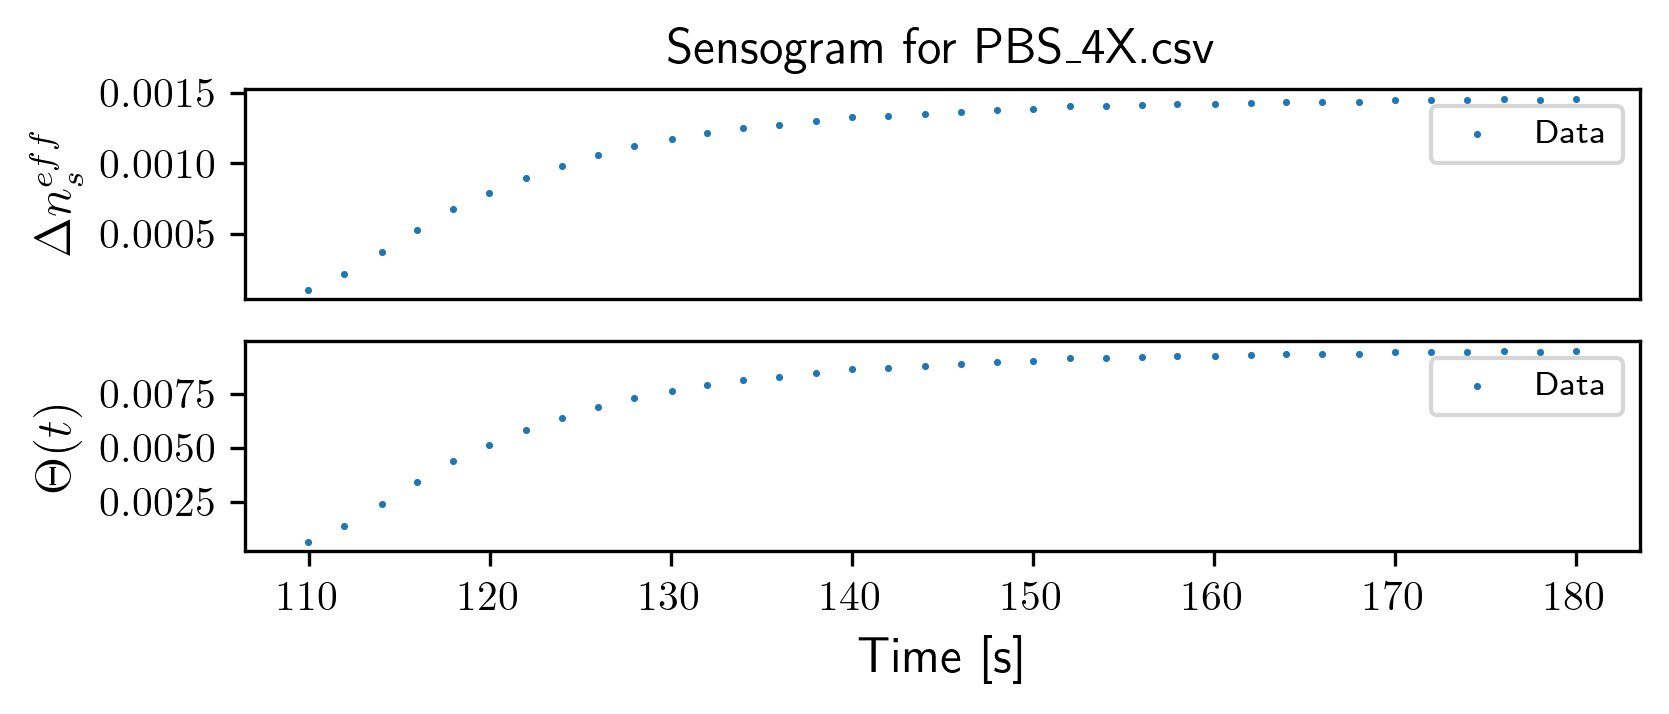

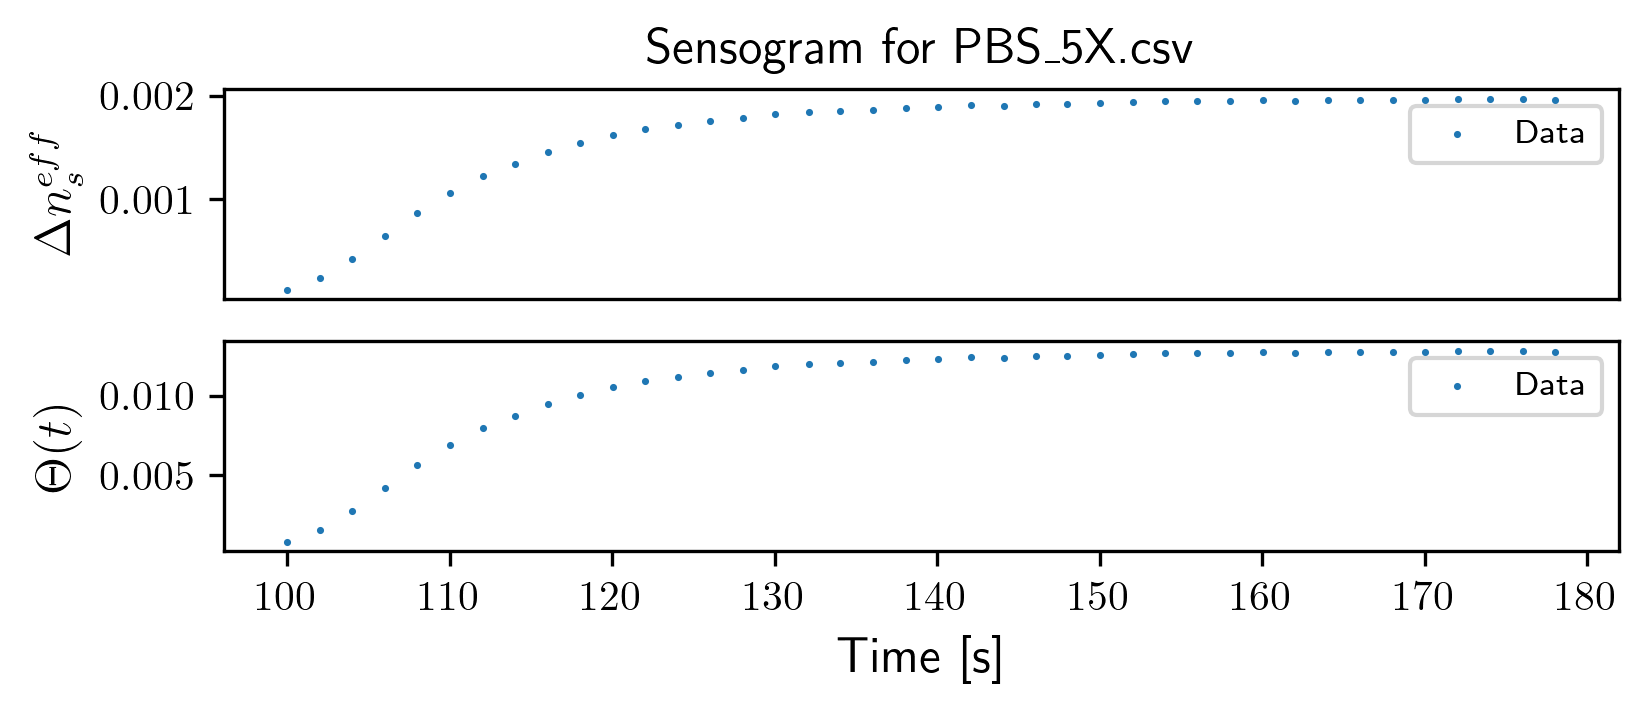

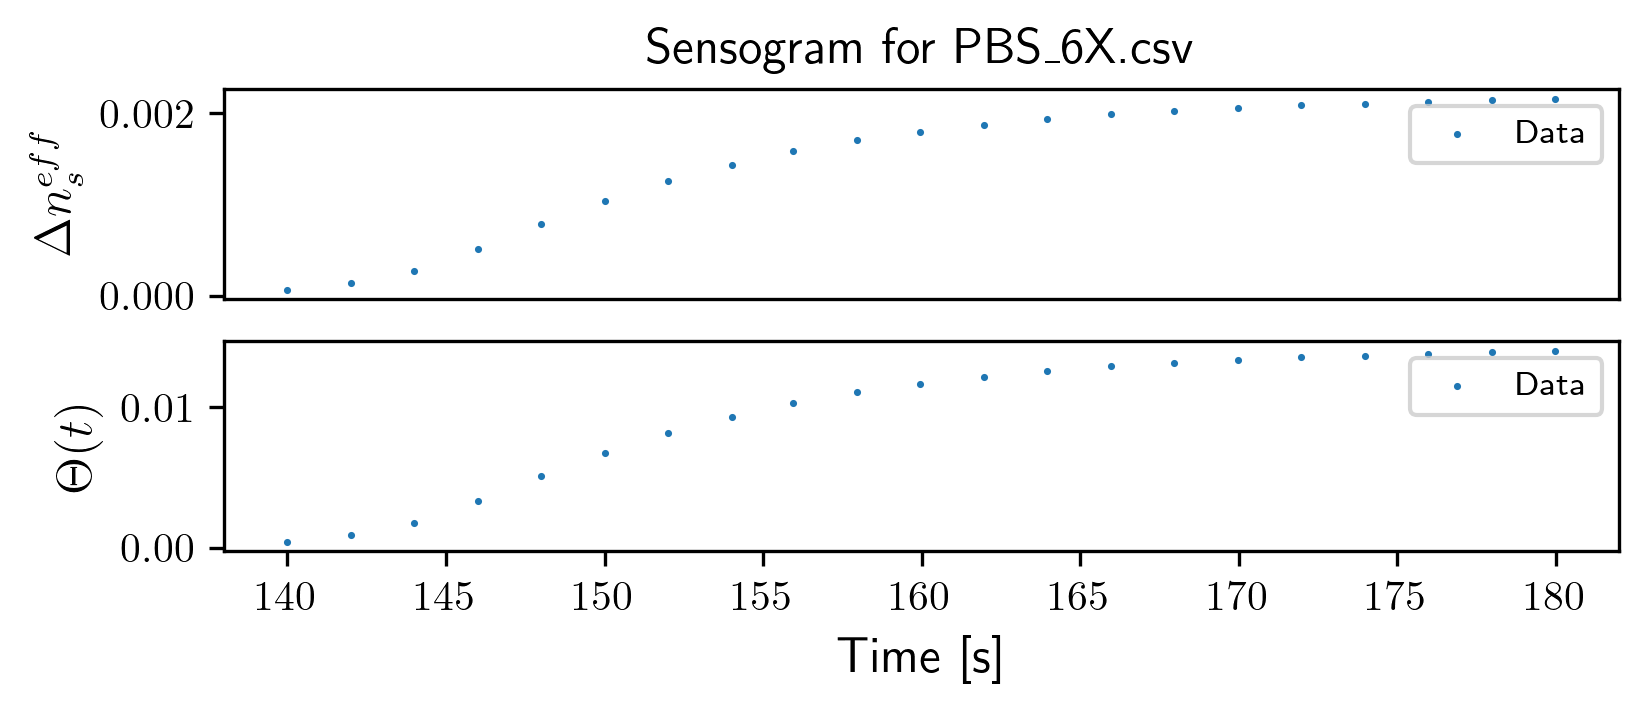

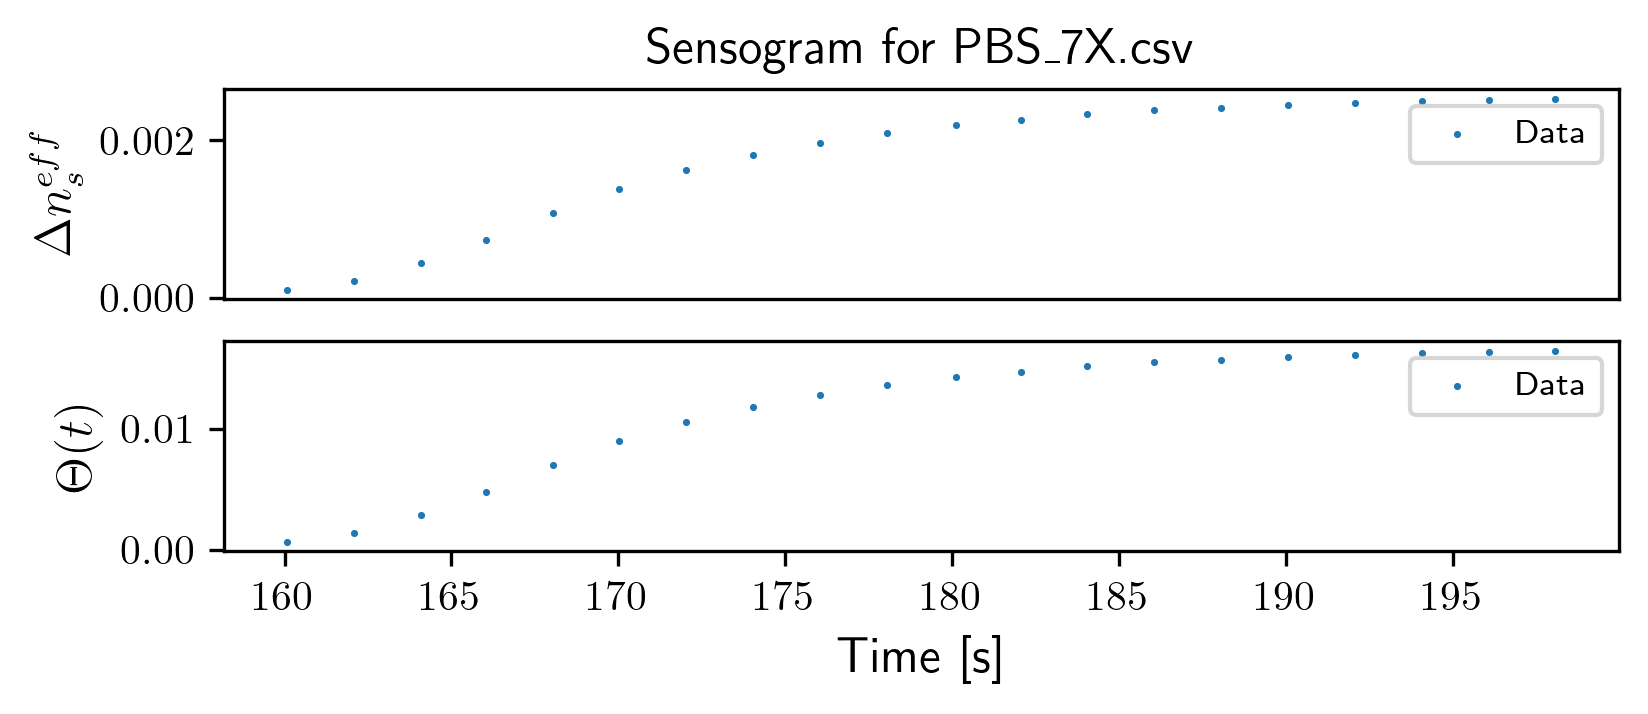

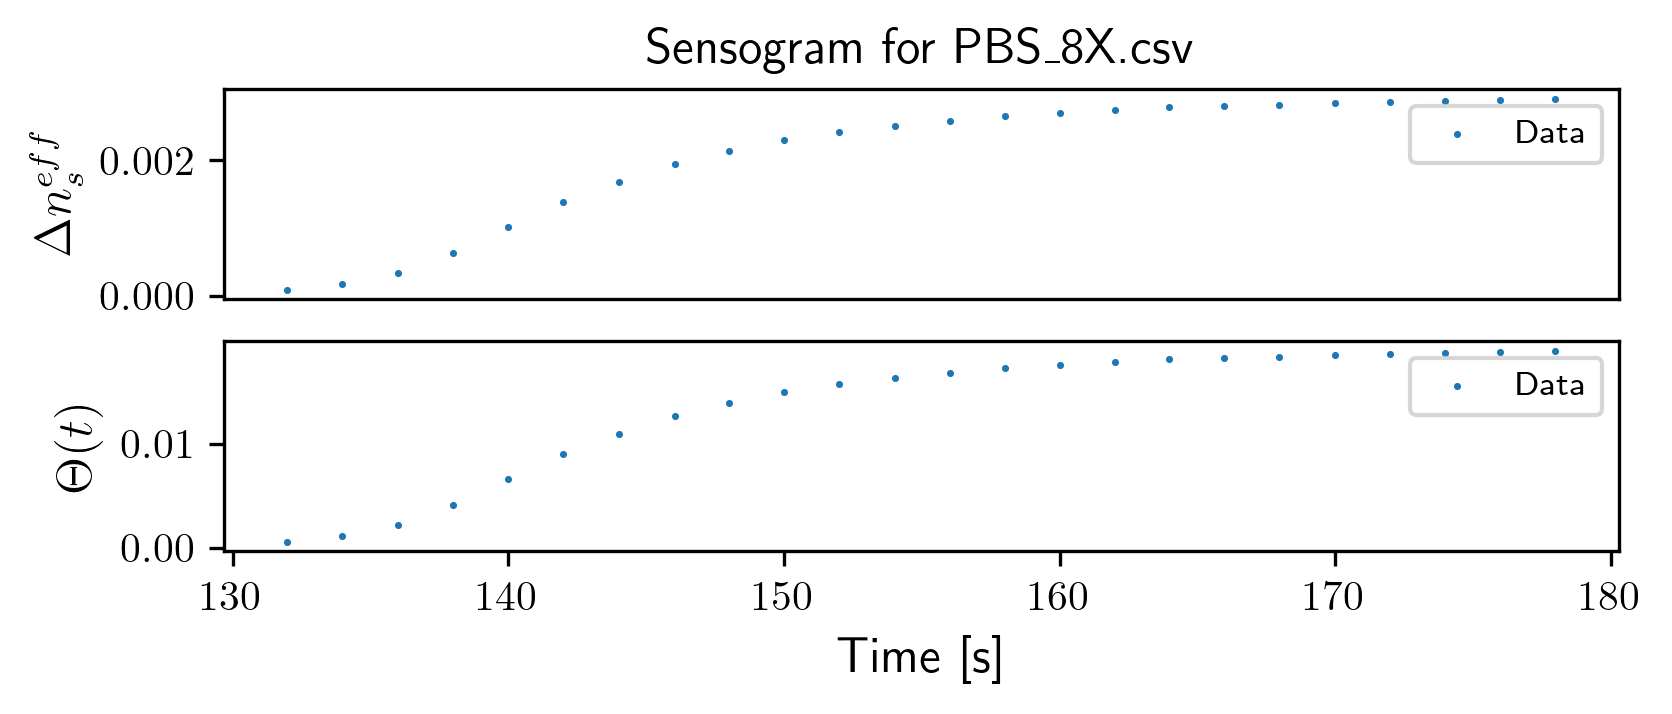

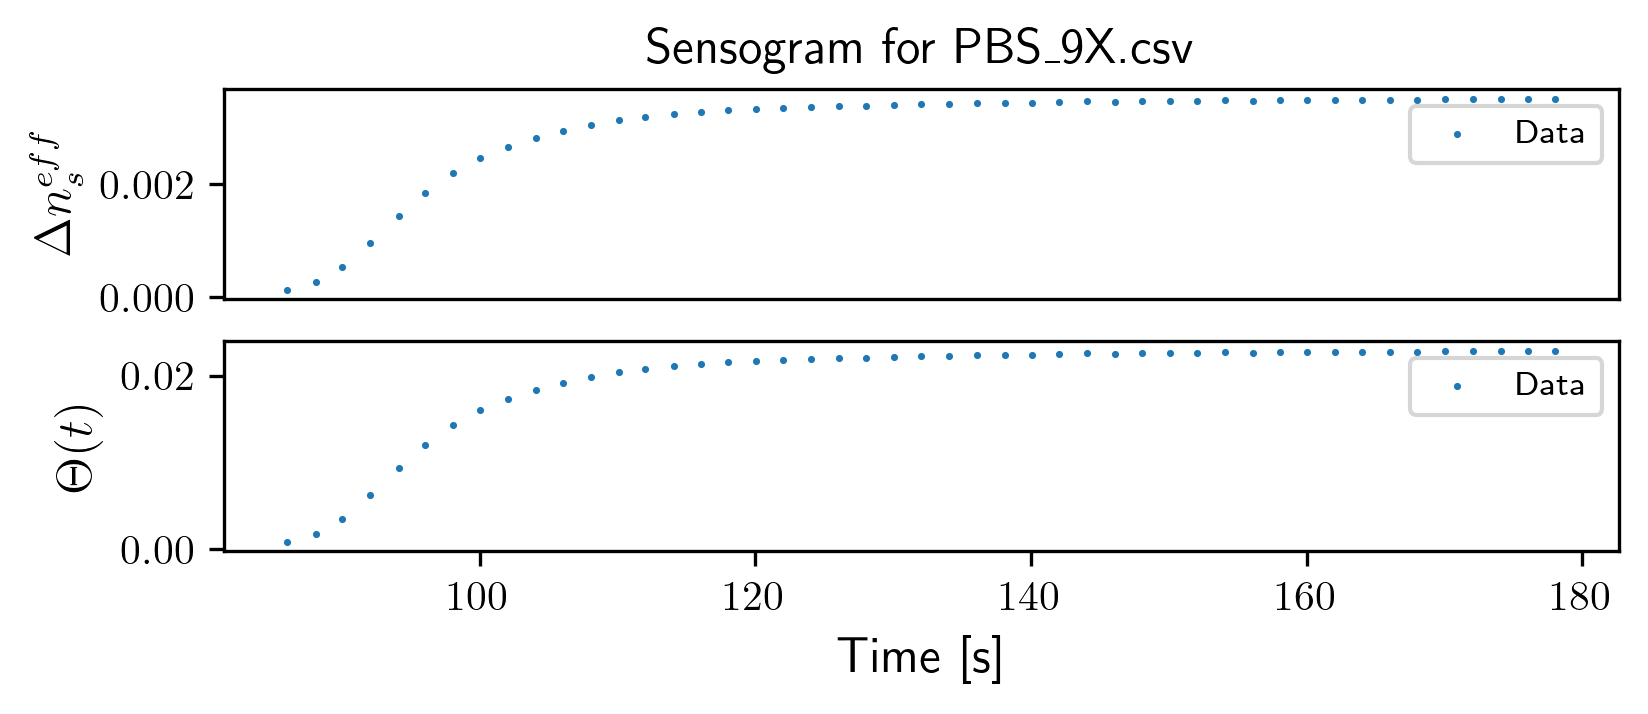

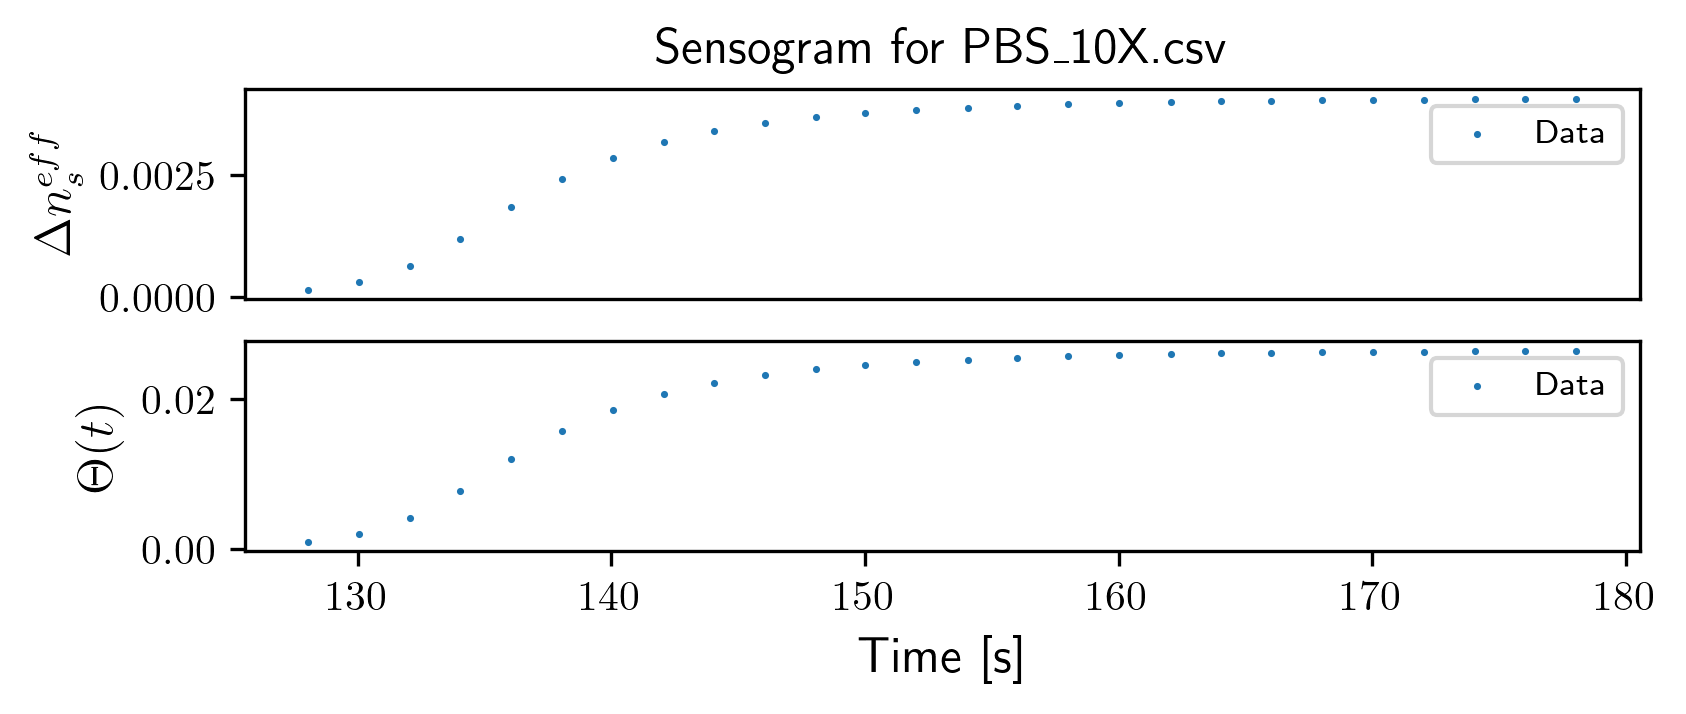

In [14]:
# RISING

# Define the starting and ending times for each concentration
i_times = [65, 85, 68, 109, 100, 139, 159, 130, 85, 127]
f_times = [180, 180, 180, 180, 180, 180, 200, 180, 180, 180]

# Dictionary to store time and refractive index data
results = {}
t_values = []
r_values = []
# Loop through each concentration
for i in range(1, 11):
    file_name = f'PBS_{i}X.csv'
    i_time = i_times[i-1]
    f_time = f_times[i-1]

    interval = np.squeeze(np.where((data_dict[file_name]['Time'] >= i_time) & (data_dict[file_name]['Time'] <= f_time)))
    t = data_dict[file_name]['Time'][interval]
    t_values.append(jnp.array(t))
    ref = data_dict[file_name][' Refractive Index'][interval]
    r_values.append(jnp.array(ref))
    
    
    #print(C_values[i-1],print(np.array(ref)[0]))
    # Store the time and refractive index data
    results[file_name] = {'Time': t, 'Refractive Index': ref}

    # Show the sensogram
    fig, (ax,ax1) = plt.subplots(2,1,figsize=(6, 2), dpi=300)
    ax.scatter(t, ref, s = 0.5, label = 'Data')
    ax.set_ylabel(r'$\Delta n_s^{eff}$')
    ax.set_title(f'Sensogram for {file_name}')
    ax.axes.get_xaxis().set_visible(False)
    ax.legend(fontsize = 8)

    ax1.scatter(t, ref/N_mol_max_opt, s = 0.5, label = 'Data')
    ax1.set_ylabel(r'$\Theta(t)$')
    ax1.set_xlabel(r'Time [s]')
    ax1.legend(fontsize = 8)


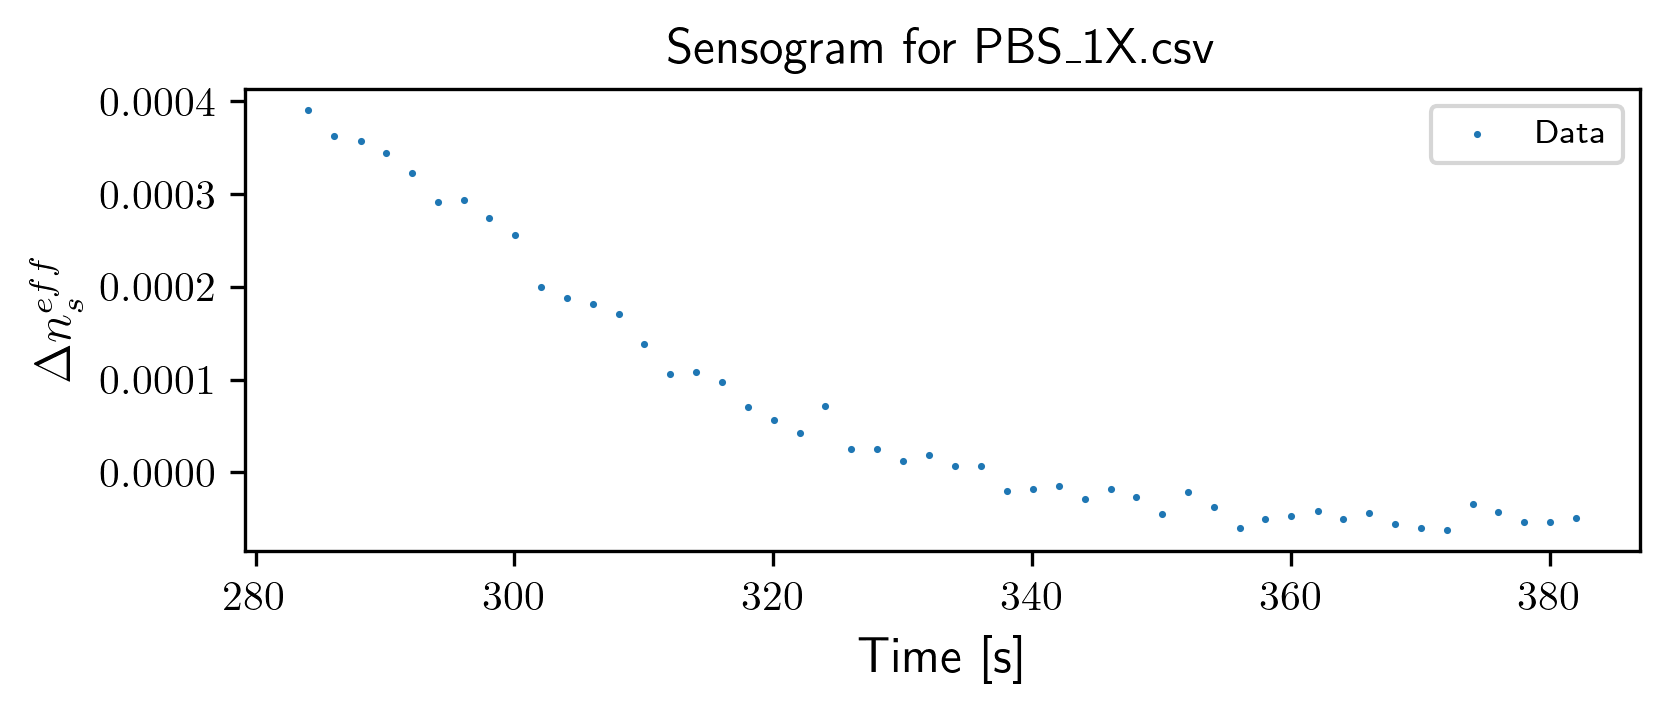

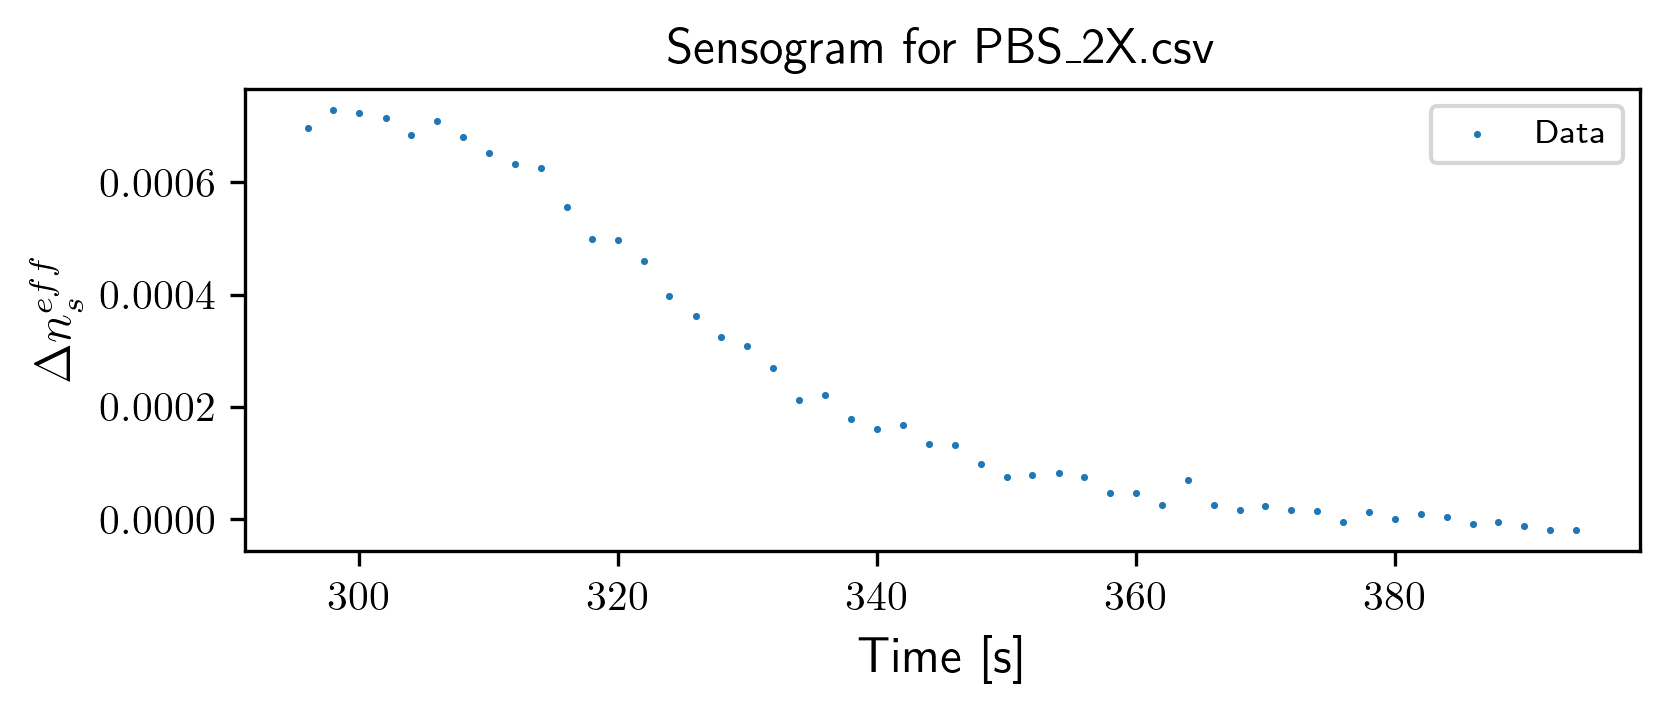

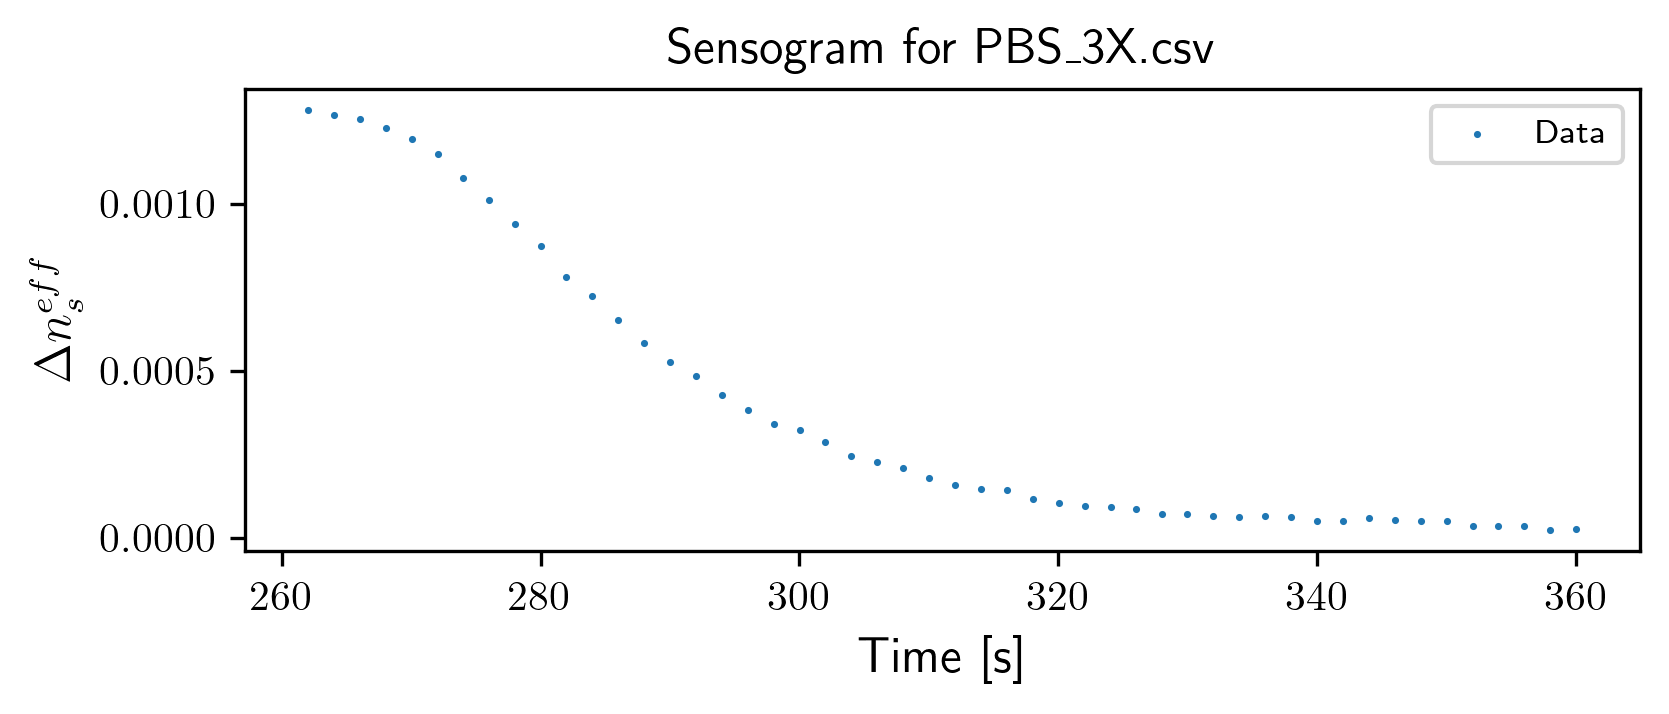

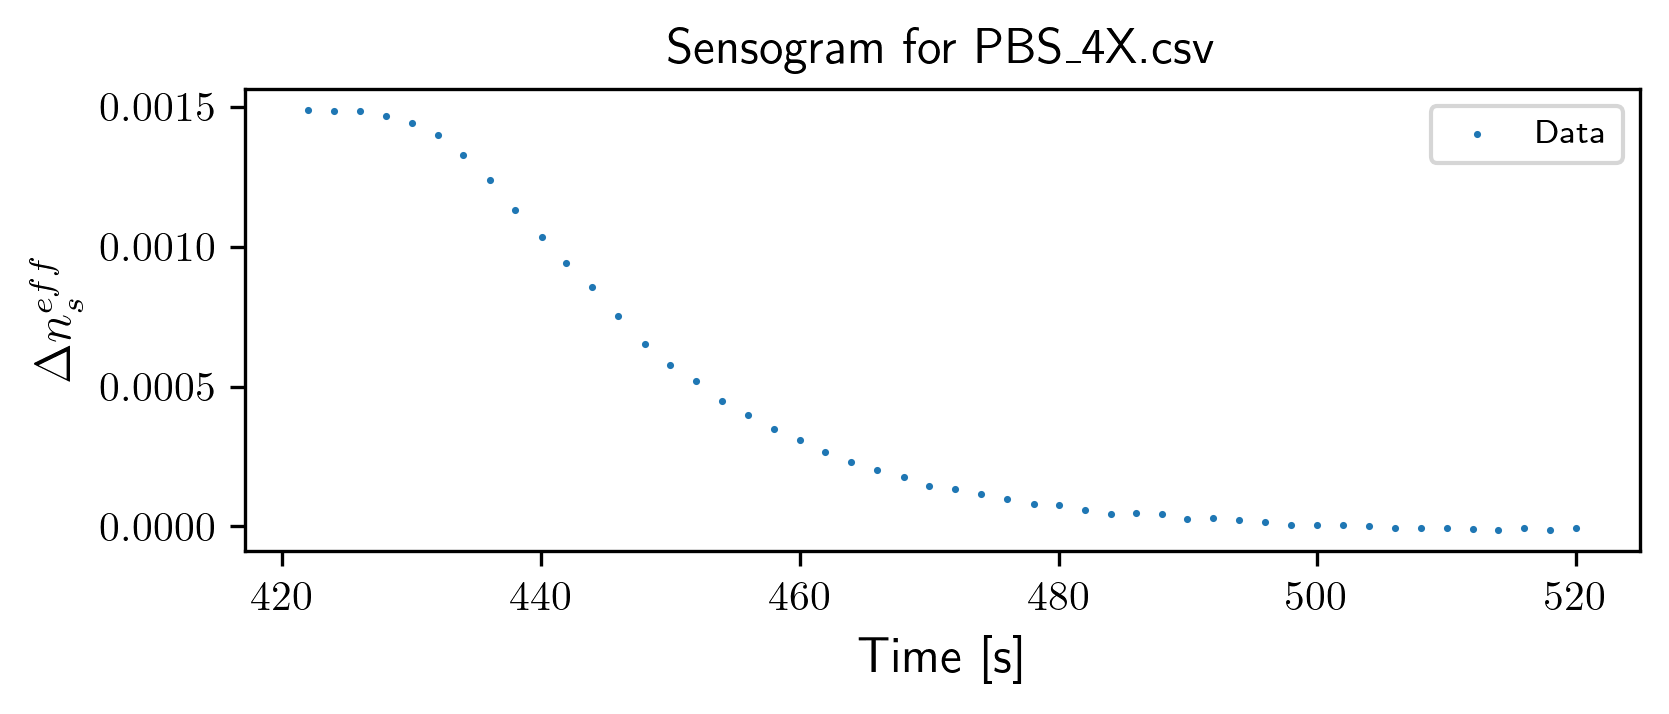

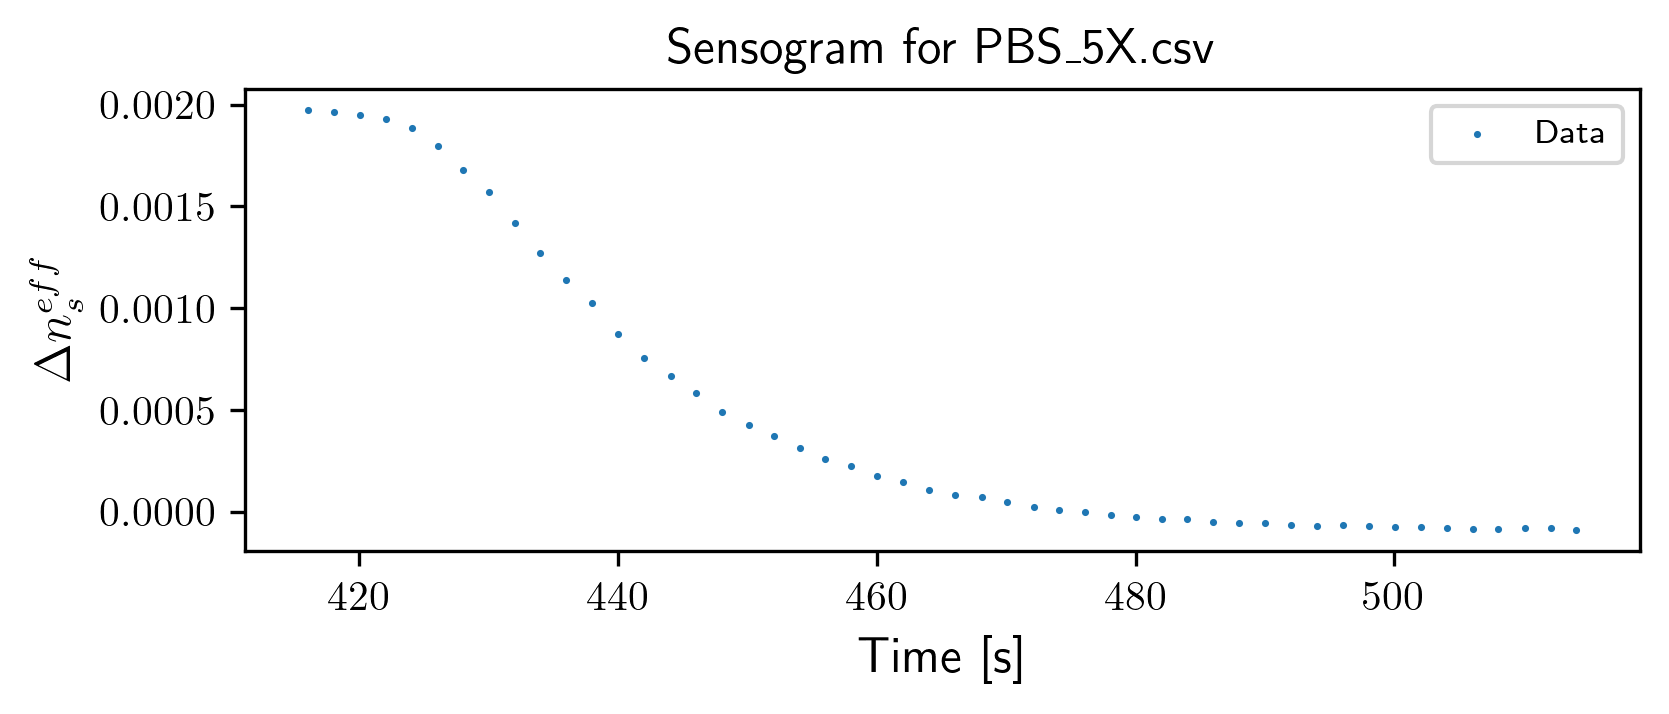

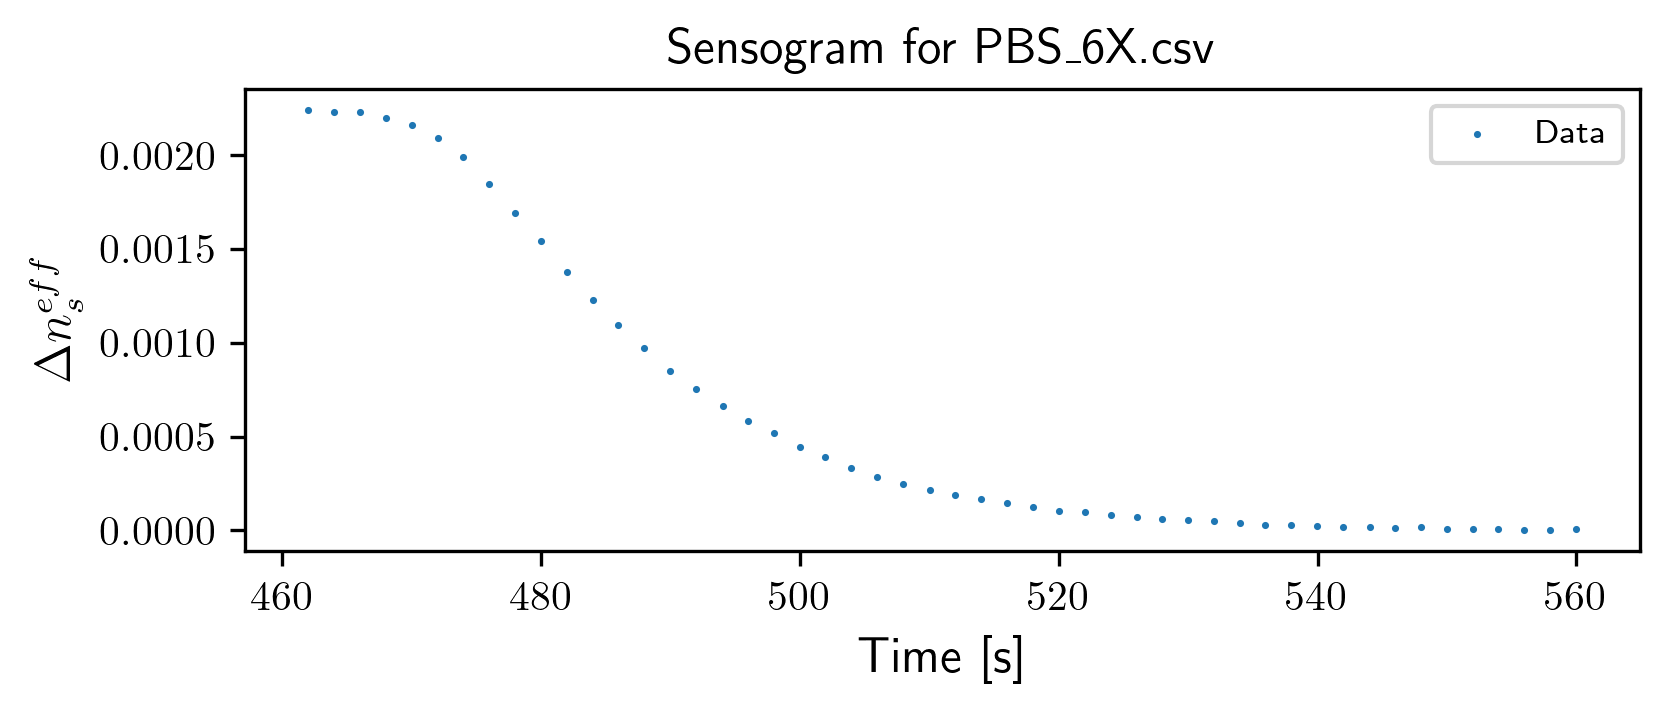

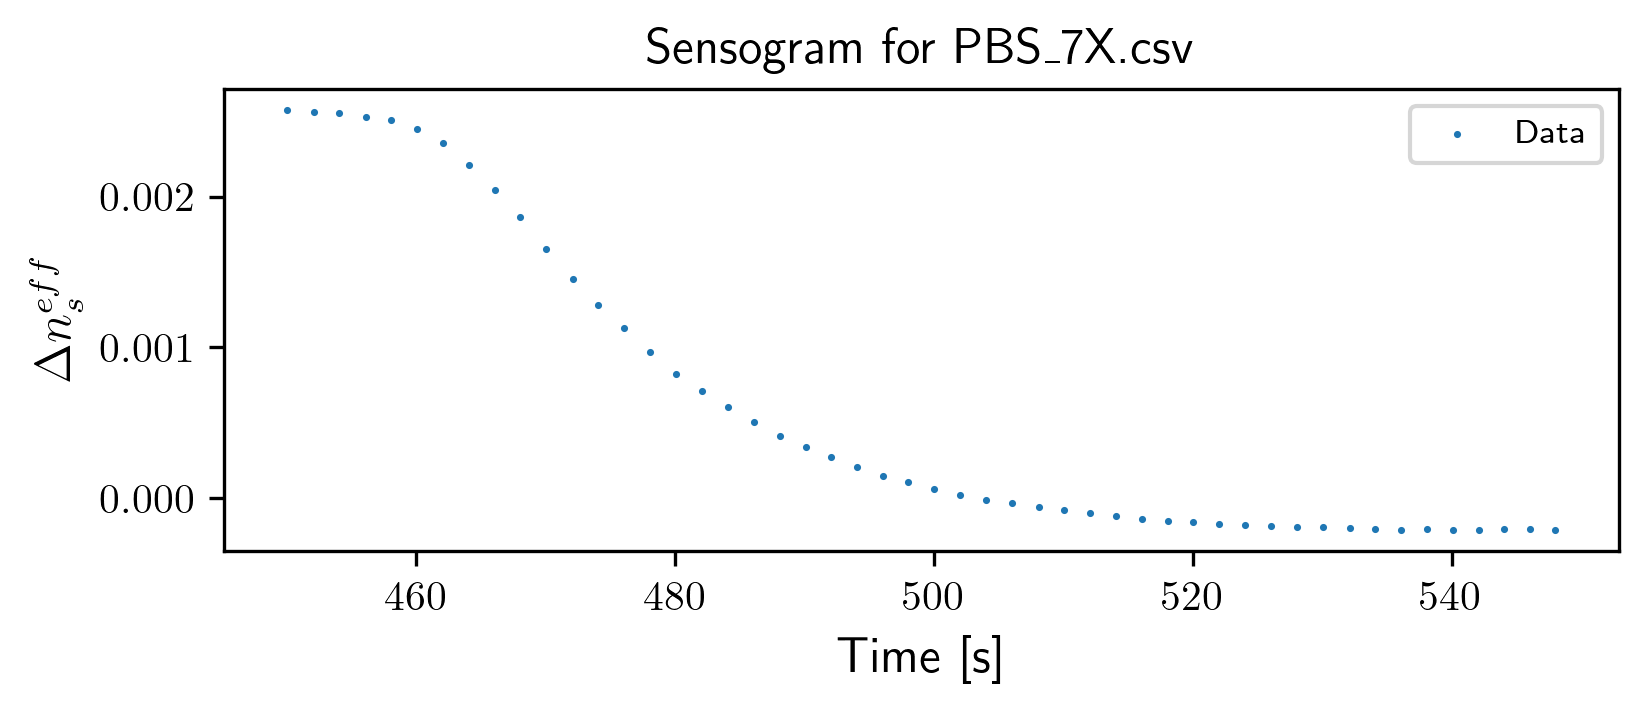

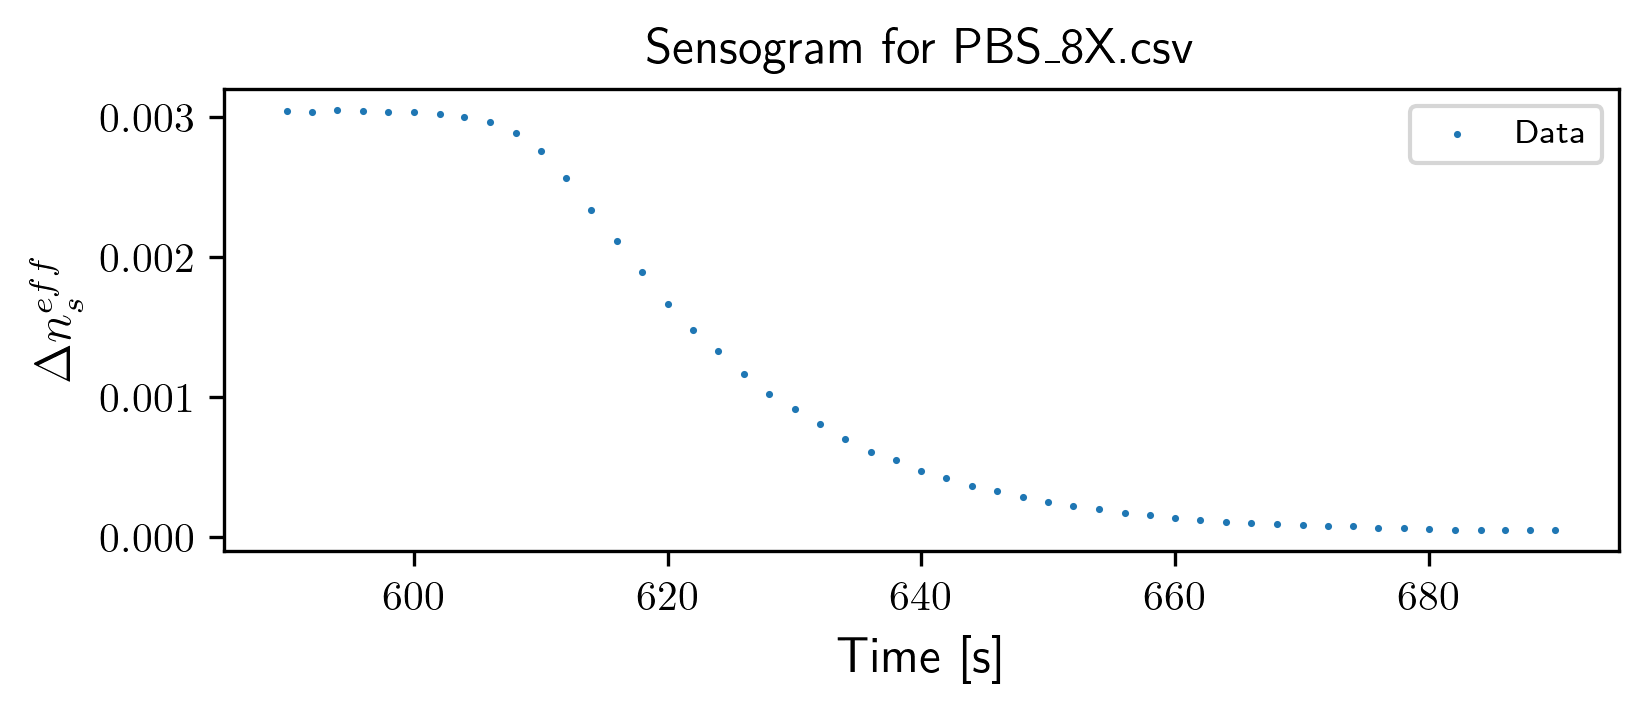

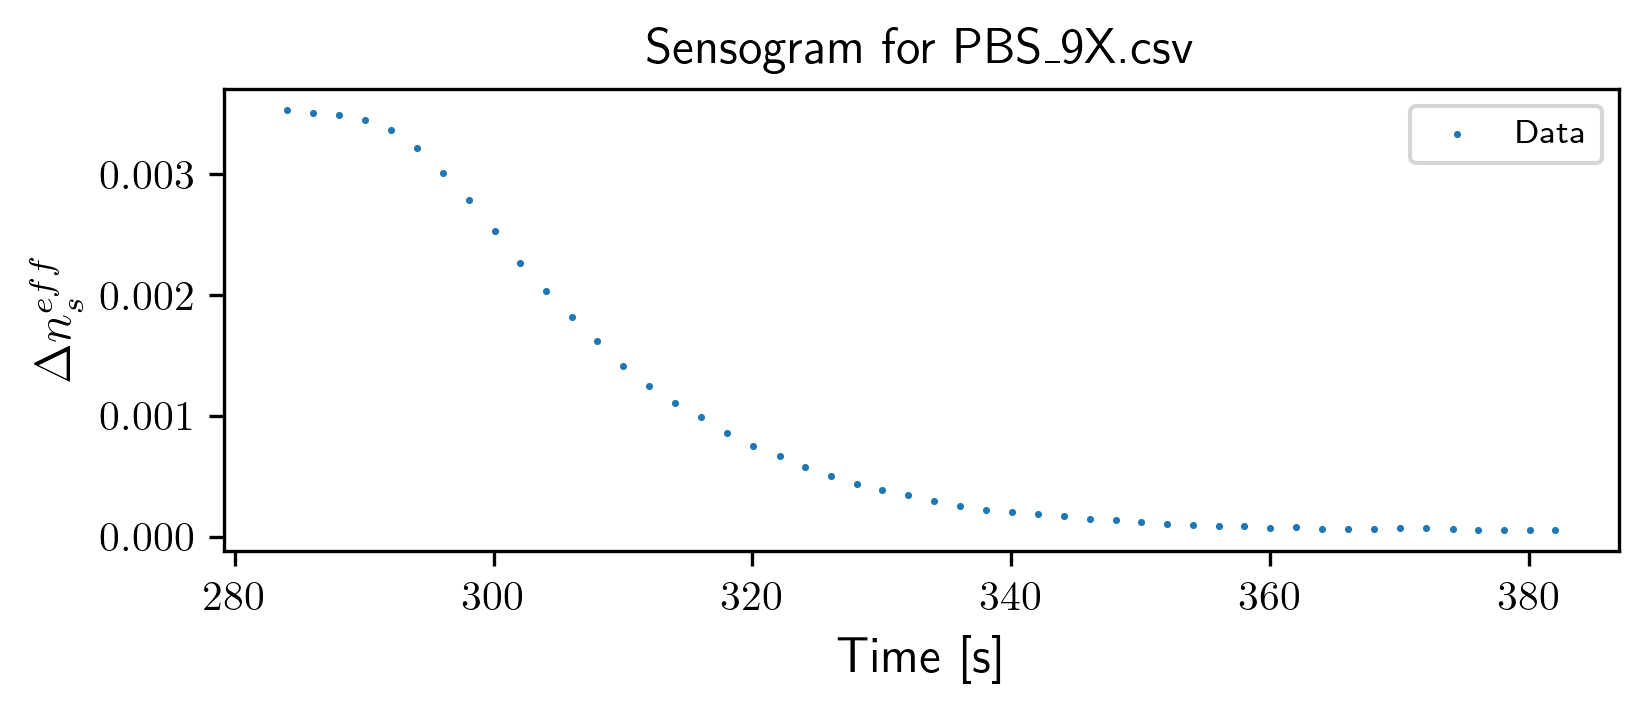

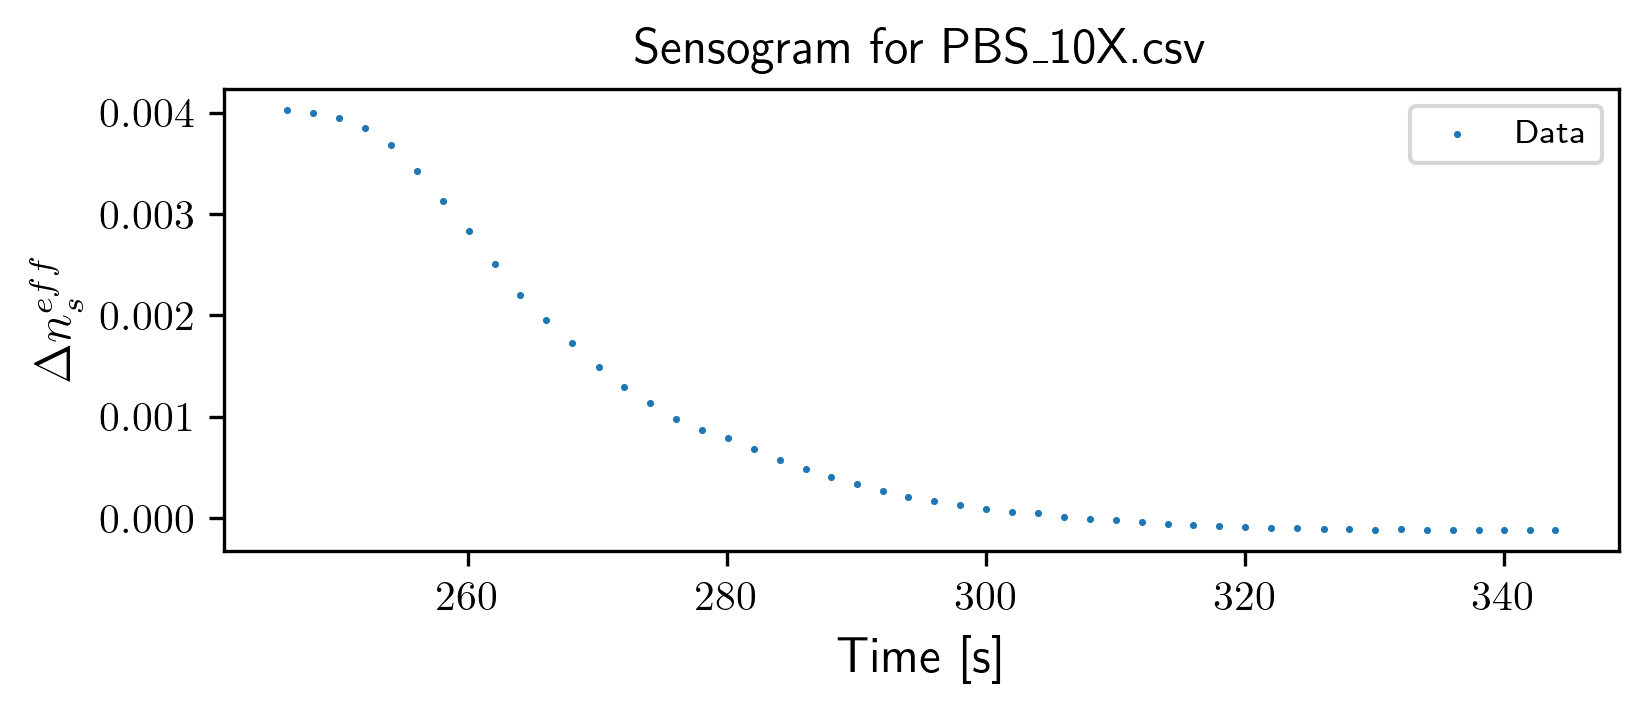

In [15]:
# Define the starting and ending times for each concentration
i_times = [284, 296, 262, 420, 415, 460, 450, 590, 284, 246]
f_times = [284 + 100, 296+100, 262+100, 420+100, 415+100, 460+100, 450+100, 590+100, 284+100, 246+100]


# Dictionary to store time and refractive index data
results = {}
t_values_d = []
r_values_d = []
# Loop through each concentration
for i in range(1, 11):
    file_name = f'PBS_{i}X.csv'
    i_time = i_times[i-1]
    f_time = f_times[i-1]

    interval = np.squeeze(np.where((data_dict[file_name]['Time'] >= i_time) & (data_dict[file_name]['Time'] <= f_time)))
    t = data_dict[file_name]['Time'][interval]
    t_values_d.append(jnp.array(t))
    ref = data_dict[file_name][' Refractive Index'][interval]
    r_values_d.append(jnp.array(ref))
    # Show the sensogram
    fig, (ax) = plt.subplots(1,1,figsize=(6, 2), dpi=300)
    ax.scatter(t, ref, s = 0.5, label = 'Data')
    ax.set_ylabel(r'$\Delta n_s^{eff}$')
    ax.set_xlabel(r'Time [s]')
    ax.set_title(f'Sensogram for {file_name}')
    # removing the x axis from the ax figure
    ax.legend(fontsize = 8)

In [16]:
# Usando loops for para substituir valores negativos por zero
r_values = [[max(0, x) for x in row] for row in r_values]
#r_values_d = [[max(0, x) for x in row] for row in r_values_d]

In [17]:
from scipy.interpolate import interp1d

# Função para normalizar o intervalo de amostragem para t_values e ajustar r_values
# Função para igualar o número de pontos dentro do intervalo de cada vetor
def equalize_sampling_same_length(t_values, r_values, desired_length):
    new_t_values = []
    new_r_values = []

    for t, r in zip(t_values, r_values):
        # Determinar o intervalo do vetor original
        t_min, t_max = t[0], t[-1]

        # Criar novo vetor de tempo com número fixo de pontos dentro do intervalo original
        new_t = np.linspace(t_min, t_max, desired_length)

        # Interpolação linear para o vetor de r_values associado
        interp_func_r = interp1d(t, r, kind='linear', fill_value="extrapolate")
        interpolated_r = interp_func_r(new_t)

        # Adicionar novos valores aos resultados
        new_t_values.append(new_t)
        new_r_values.append(interpolated_r)

    return new_t_values, new_r_values

# Exemplo de uso
desired_dt = 2.0  # Define o intervalo de amostragem desejado
desired_length = 57
new_t_values, new_r_values = equalize_sampling_same_length(t_values[2:], r_values[2:], desired_length)
#new_t_valuesd, new_r_valuesd = equalize_sampling_same_length(t_values_d[2:], r_values_d[2:], desired_dt)
C_values_new = C_values[2:] 
#C_values_new = C_values_new[1]
#new_t_values, new_r_values = new_t_values[1], new_r_values[1]

In [18]:
# import numpy as np
# from scipy.interpolate import interp1d

# # Função para normalizar o intervalo de amostragem para t_values e ajustar r_values
# # Define o intervalo de amostragem desejado (sampling rate)
# def equalize_sampling_fixed_rate(t_values, r_values, desired_dt):
#     new_t_values = []
#     new_r_values = []

#     for t, r in zip(t_values, r_values):
#         # Determinar o intervalo do vetor original
#         t_min, t_max = t[0], t[-1]

#         # Criar novo vetor de tempo com base no intervalo desejado
#         new_t = np.arange(t_min, t_max, desired_dt)

#         # Interpolação linear para o vetor de r_values associado
#         interp_func_r = interp1d(t, r, kind='linear', fill_value="extrapolate")
#         interpolated_r = interp_func_r(new_t)

#         # Adicionar novos valores aos resultados
#         new_t_values.append(new_t)
#         new_r_values.append(interpolated_r)
#         print(len(t),len(new_t))

#     return new_t_values, new_r_values

# # Exemplo de uso
# desired_dt = 2.0  # Define o intervalo de amostragem desejado (e.g., 2.0 unidades de tempo)
# new_t_values, new_r_values = equalize_sampling_fixed_rate(t_values[2:], r_values[2:], desired_dt)
# #new_t_valuesd, new_r_valuesd = equalize_sampling_fixed_rate(t_values_d[2:], r_values_d[2:], desired_dt)
# C_values_new = C_values[2:] 

In [19]:
t_values_train = new_t_values#list(new_t_values[int(len(new_t_values)*0.7):int(len(new_t_values)*0.85)]) #+ list(new_t_valuesd[int(len(new_t_valuesd)*0.7):int(len(new_t_valuesd)*0.85)])
t_values_test = t_values_train#list(new_t_values[int(len(new_t_values)*0.85):]) #+ list(new_t_valuesd[int(len(new_t_valuesd)*0.85):])
t_values_val = t_values_test

r_values_train = new_r_values#list(new_r_values[:int(len(new_r_values)*0.7)]) #+ list(new_r_valuesd[:int(len(new_r_valuesd)*0.7)])
r_values_val = new_r_values#list(new_r_values[int(len(new_r_values)*0.7):int(len(new_r_values)*0.85)]) #+ list(new_r_valuesd[int(len(new_r_valuesd)*0.7):int(len(new_r_valuesd)*0.85)])
r_values_test = new_r_values#list(new_r_values[int(len(new_r_values)*0.85):]) #+ list(new_r_valuesd[int(len(new_r_valuesd)*0.85):])

C_values_train = C_values_new#list(C_values_new[:int(len(C_values_new)*0.7)]) #+ list(C_values_new[:int(len(C_values_new)*0.7)])
C_values_val = C_values_new#list(C_values_new[int(len(C_values_new)*0.7):int(len(C_values_new)*0.85)]) #+ list(C_values_new[int(len(C_values_new)*0.7):int(len(C_values_new)*0.85)])
C_values_test = C_values_new#list(C_values_new[int(len(C_values_new)*0.85):]) #+ list(C_values_new[int(len(C_values_new)*0.85):])new_r_values[int(len(new_r_values)*0.85):]) #+ list(new_r_valuesd[int(len(new_r_valuesd)*0.85):])

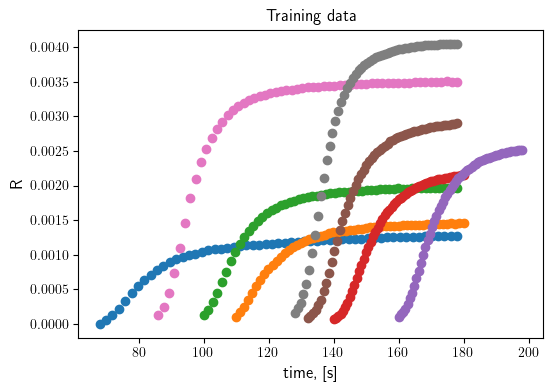

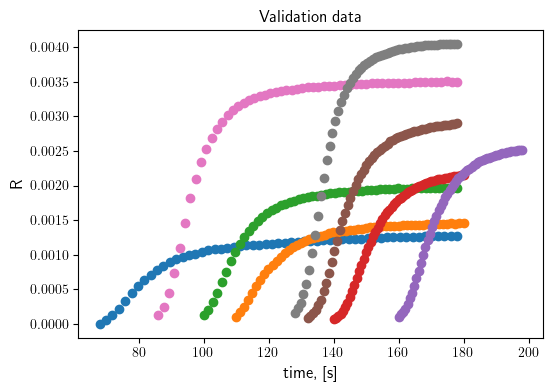

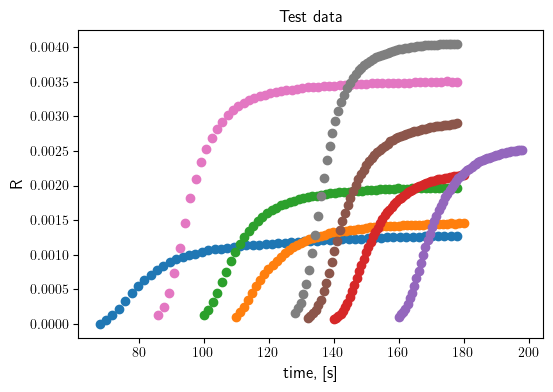

In [20]:
# plots
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Training data")
ax.set_xlabel("time, [s]")
ax.set_ylabel(r"R")

fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.set_title("Validation data")
ax2.set_xlabel("time, [s]")
ax2.set_ylabel(r"R")

fig3, ax3 = plt.subplots(figsize=(6, 4))
ax3.set_title("Test data")
ax3.set_xlabel("time, [s]")
ax3.set_ylabel(r"R")

for i in range(len(r_values_train)):
    ax.scatter(t_values_train[i], r_values_train[i])
for i in range(len(r_values_val)):
    ax2.scatter(t_values_val[i], r_values_val[i])

for i in range(len(r_values_test)):
    ax3.scatter(t_values_test[i], r_values_test[i])

# 3. Using ERA and OKID 

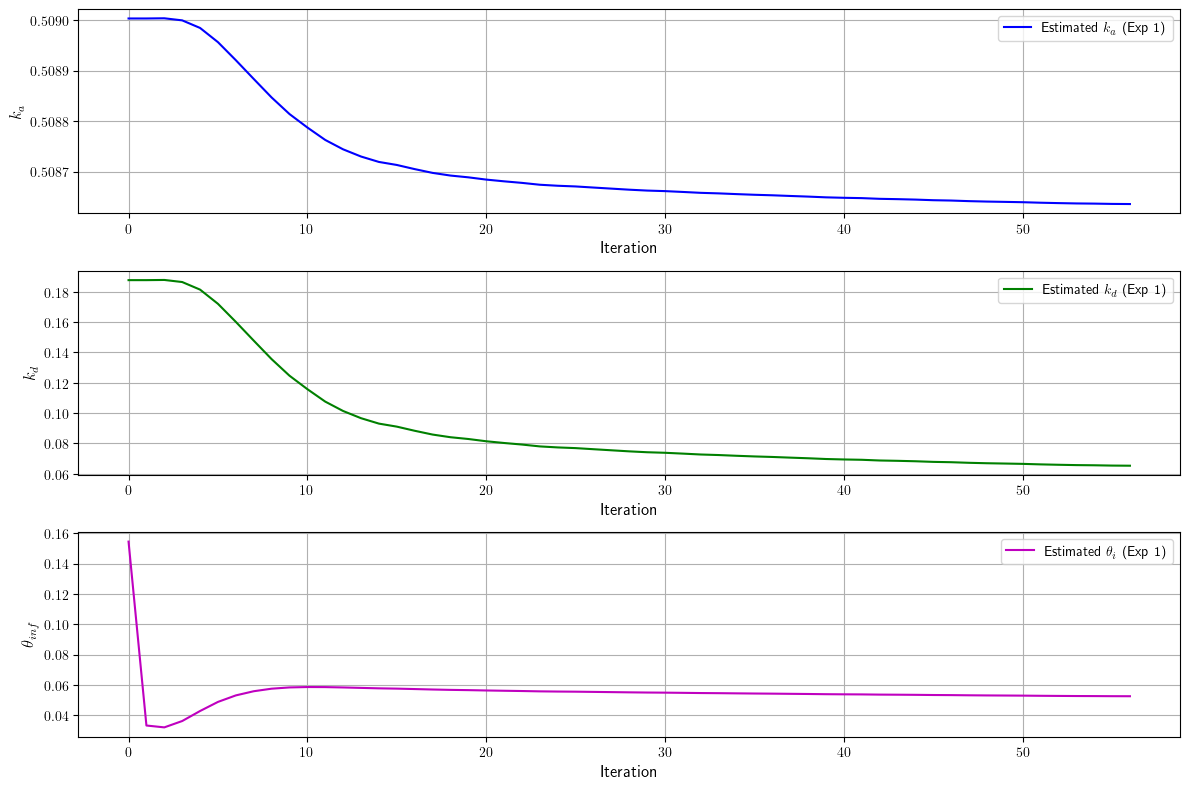

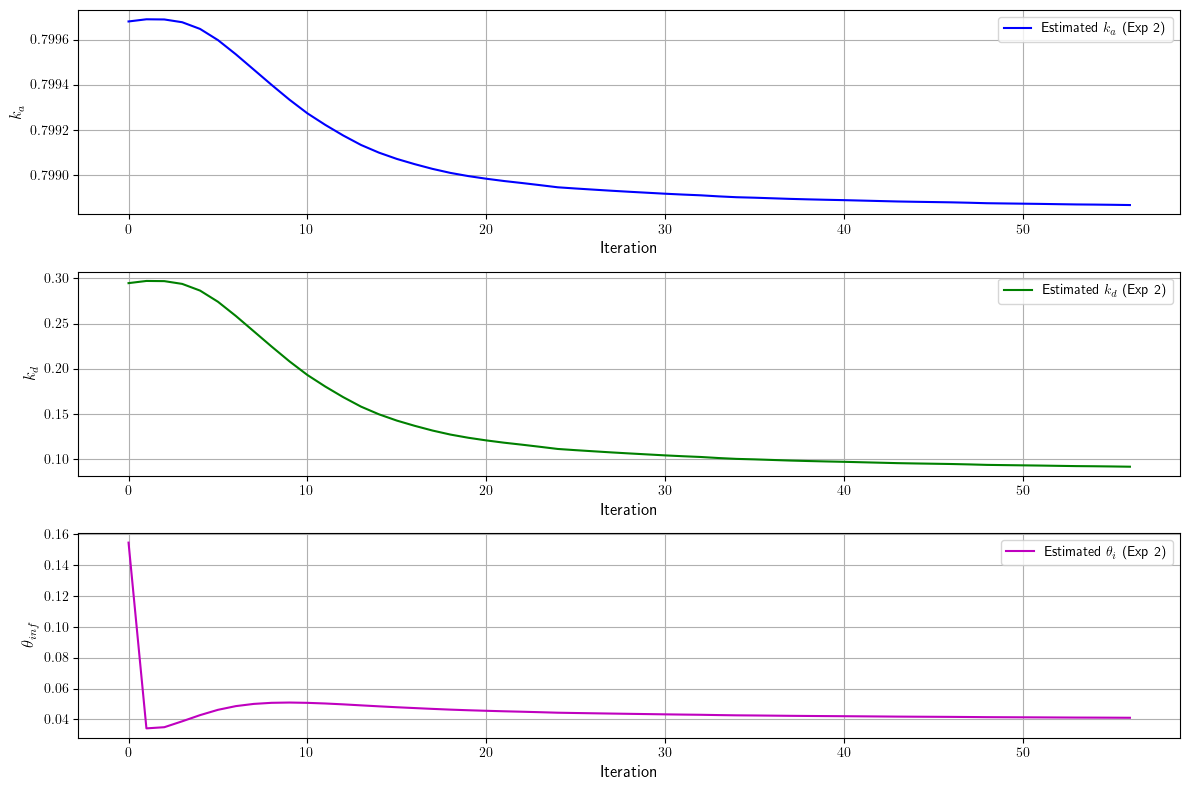

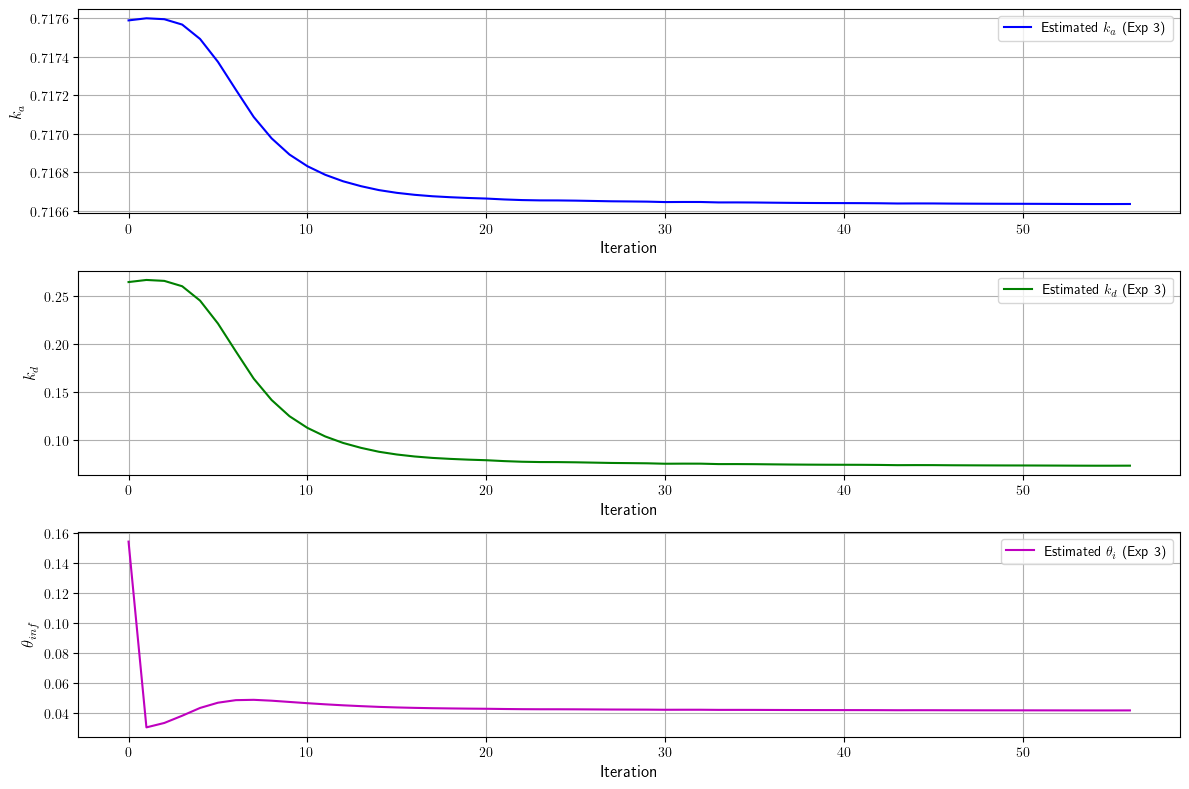

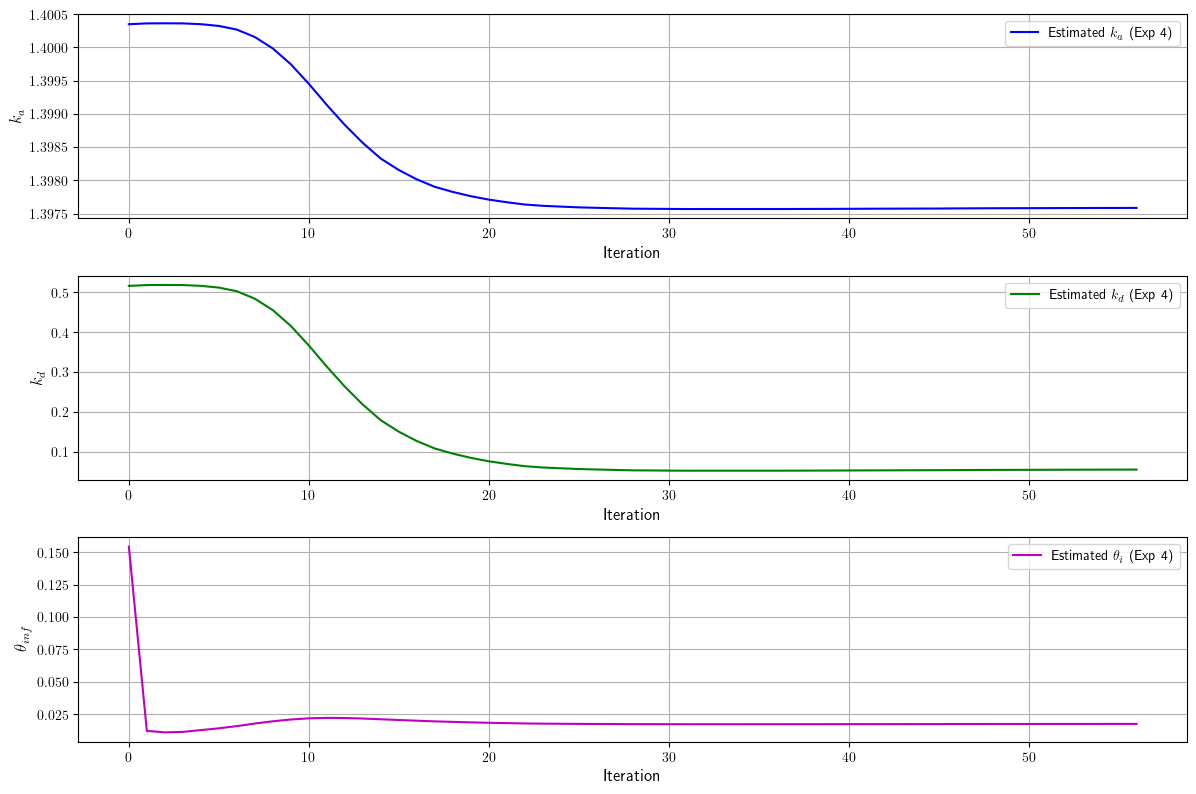

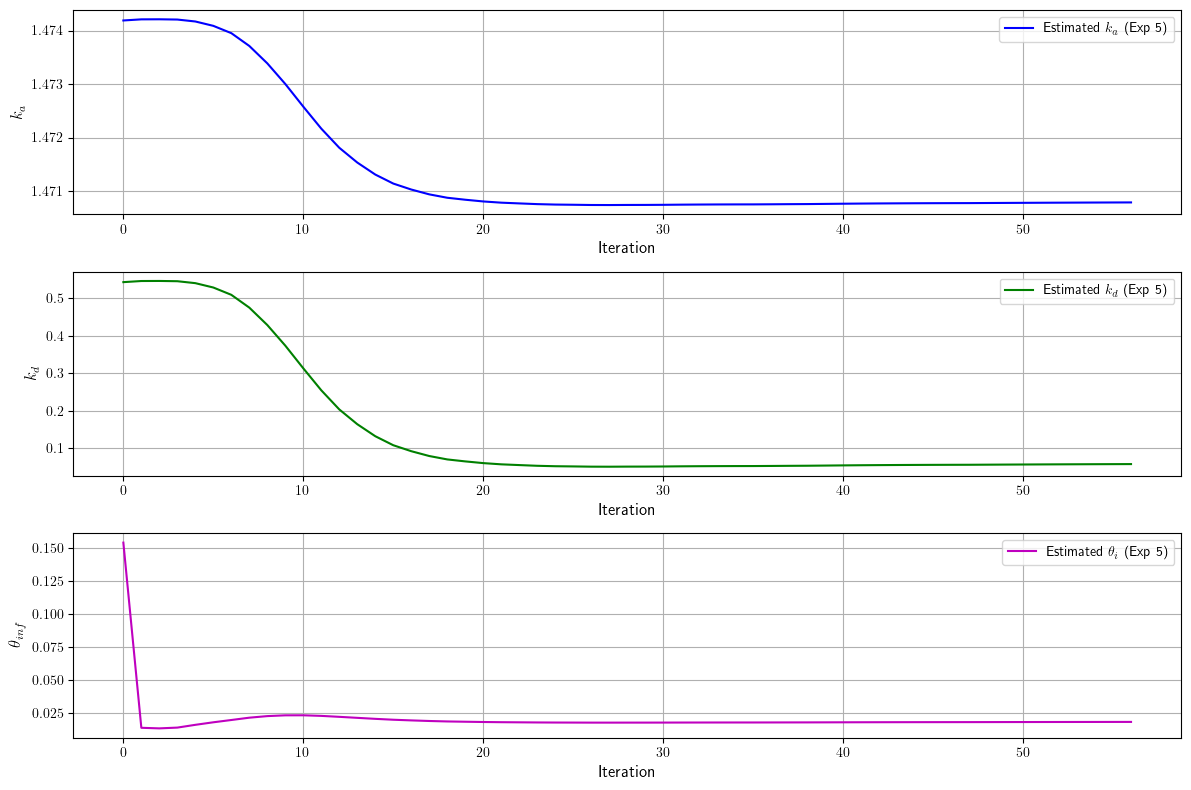

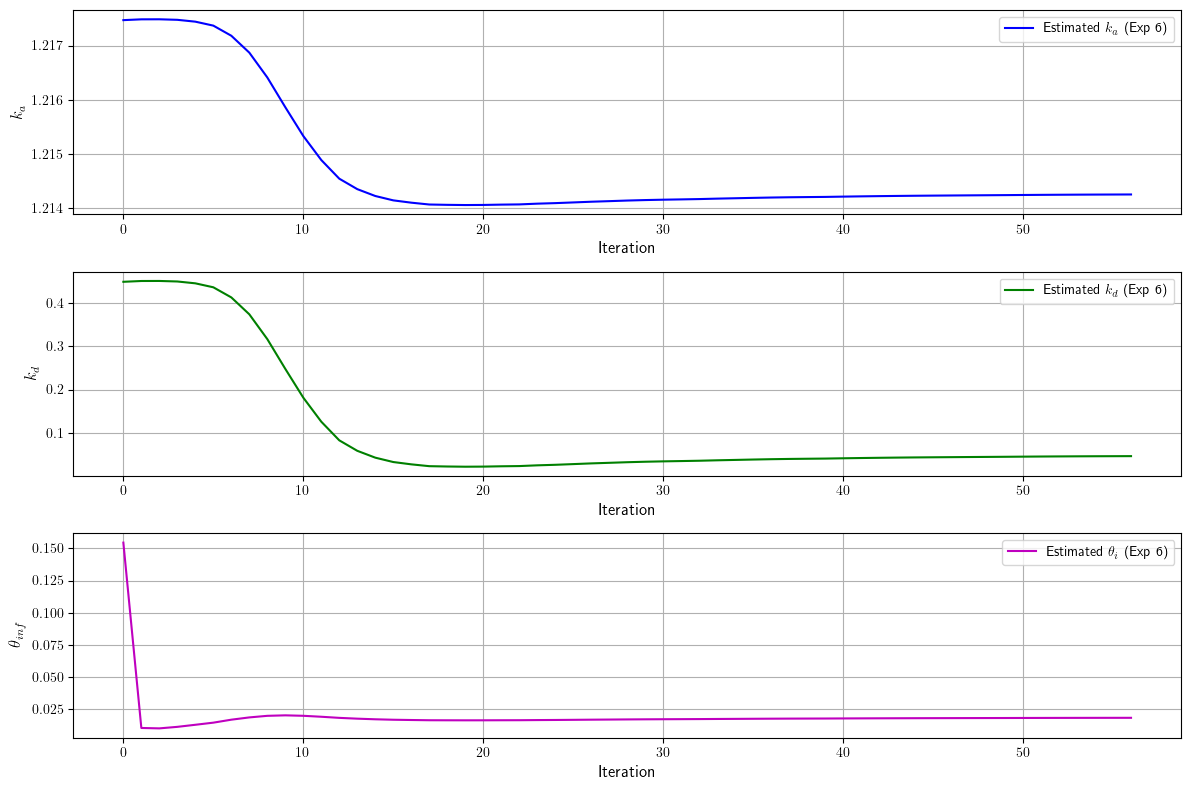

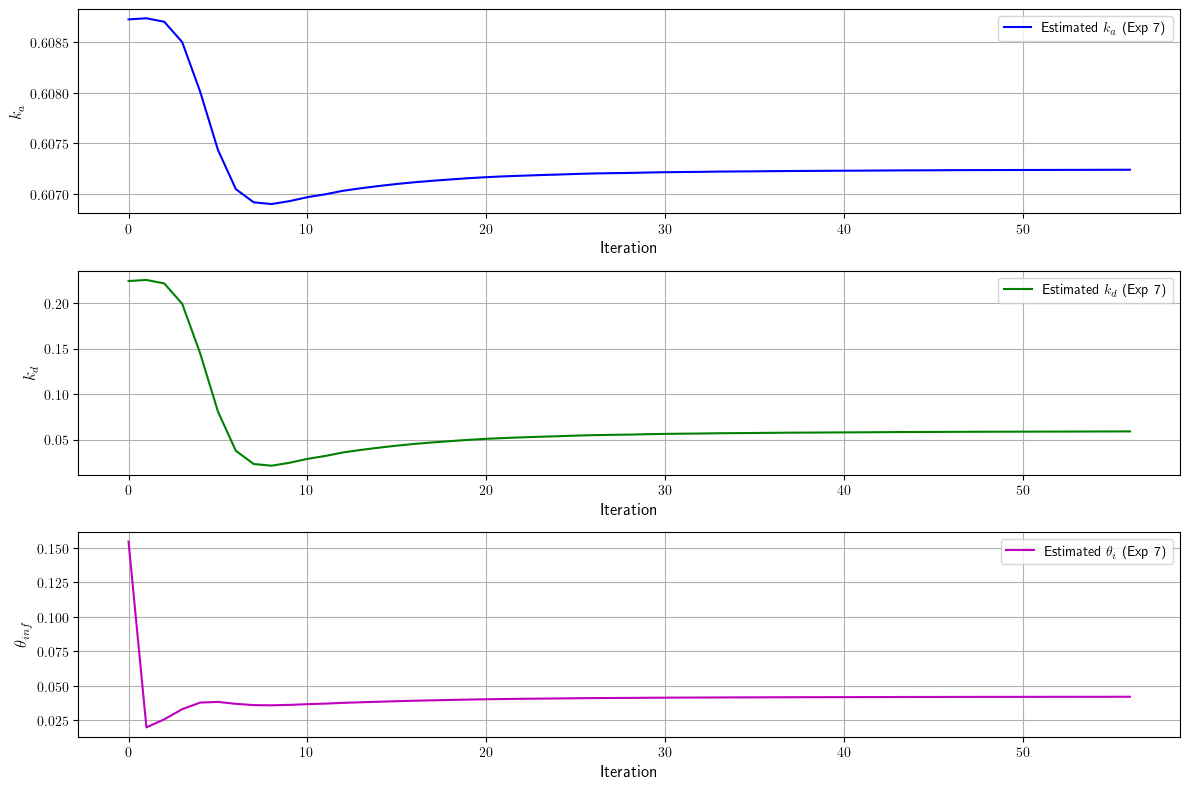

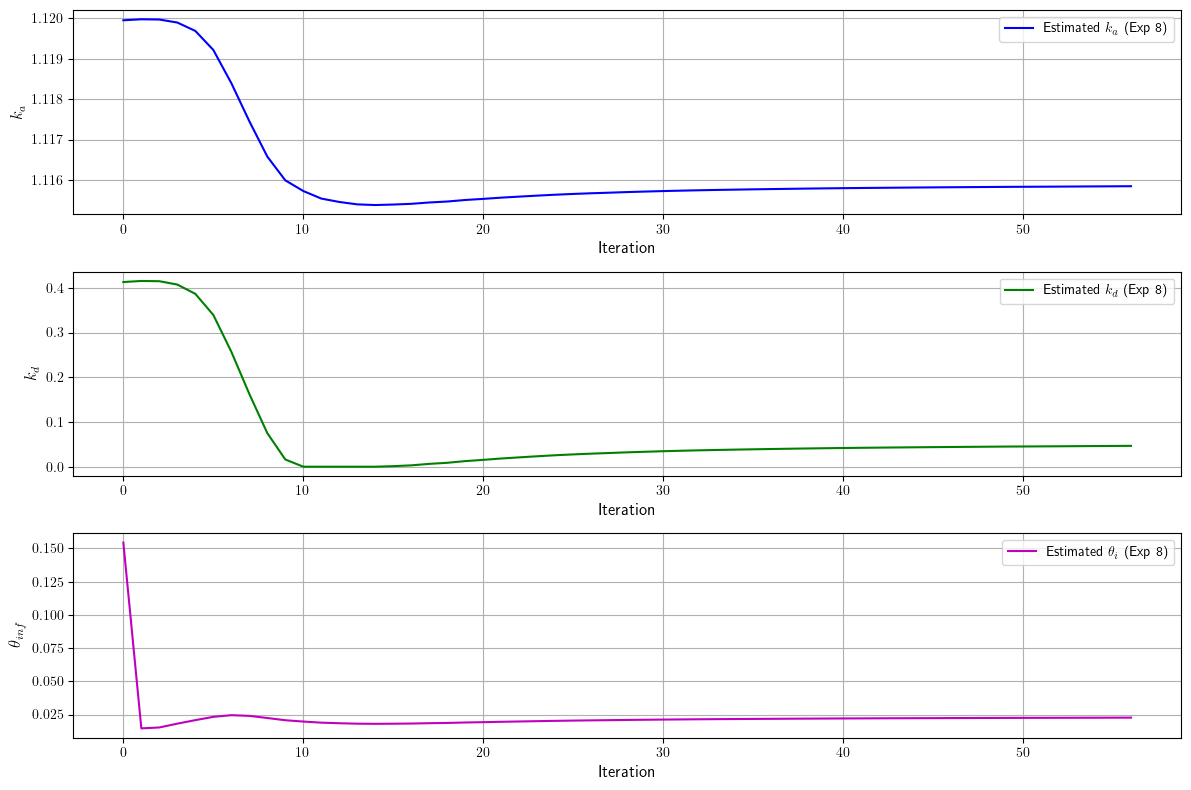

In [21]:
# Define constants and initialize parameters
n_experiments = len(C_values_new)  # Number of experiments

# Generate step-like inputs and time differences for each experiment
u_list, dt_list = [], []
for i in range(n_experiments):
    u = C_values_new[i] * np.ones(len(r_values_train[i]))
    dt = np.append(np.diff(new_t_values[i]), np.diff(new_t_values[i])[-1])
    u_list.append(u)
    dt_list.append(dt)


# Generate outputs for each experiment
y_list = r_values_train

# Recursive Least Squares (RLS) for experiment-dependent parameters
theta_experiments = []  # To store final thetas for each experiment
theta_history_per_exp = []  # To store theta history for each experiment
P = np.eye(3) * 1e6  # Covariance matrix (same for all experiments)
lambda_ = 1  # Forget factor

gamma = -1
beta = -gamma * var_n_mol_thetainf
alpha = 1 - 1 / Ka

# Initial shared parameters and covariance matrix
theta = np.array([alpha, beta, gamma])  # [alpha, beta, gamma]

# Perform RLS for each experiment sequentially
for exp_idx in range(n_experiments):
    u = u_list[exp_idx]
    y = y_list[exp_idx]
    n_points = len(y)
    
    # Track theta history for this experiment
    theta_history = []
    theta = np.array([alpha, beta, gamma])  # [alpha, beta, gamma]

    for k in range(n_points - 1):
        # Regression vector
        phi = np.array([y[k], u[k], u[k] * y[k]])
        
        # Observed output
        y_obs = y[k + 1]
        
        # Kalman gain
        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        # Store theta history for this experiment
        theta_history.append(theta.copy())
        # Update parameters
        theta += K * (y_obs - phi.T @ theta)
        
        # Enforce constraints
        theta[0] = min(theta[0], 1 - 1e-6)  # Ensure alpha < 1
        theta[1] = max(theta[1], 1e-6)     # Ensure beta > 0
        theta[2] = min(theta[2], -1e-6)    # Ensure gamma < 0

        # Update covariance matrix
        P = (P - np.outer(K, phi.T @ P)) / lambda_
    
    # Save the final theta for this experiment
    theta_history.append(theta)
    theta_experiments.append(theta.copy())
    theta_history_per_exp.append(np.array(theta_history))

    # Reset covariance matrix for the next experiment
    P = np.eye(3) * 1e6

kd_final_list = []
ka_final_list = []
theta_inf_final_list = []
# Analyze results for each experiment
for exp_idx in range(n_experiments):
    theta_history = theta_history_per_exp[exp_idx]
    dt = dt_list[exp_idx]
    # Recover system parameters from theta
    alpha_history = theta_history[:, 0]
    beta_history = theta_history[:, 1]
    gamma_history = theta_history[:, 2]

    kd_history = (1 - alpha_history) / dt
    ka_history = -gamma_history / dt
    theta_inf_history = beta_history / (ka_history * dt)
    kd_final_list.append(kd_history[-1])
    ka_final_list.append(ka_history[-1])
    theta_inf_final_list.append(theta_inf_history[-1])


    # Plot the parameter convergence
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(ka_history, label=f"Estimated $k_a$ (Exp {exp_idx+1})", color='b')
    plt.xlabel("Iteration")
    plt.ylabel("$k_a$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(kd_history, label=f"Estimated $k_d$ (Exp {exp_idx+1})", color='g')
    plt.xlabel("Iteration")
    plt.ylabel("$k_d$")
    plt.legend()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(theta_inf_history, label=f"Estimated $\\theta_i$ (Exp {exp_idx+1})", color='m')
    plt.xlabel("Iteration")
    plt.ylabel("$\\theta_{inf}$")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


ka 0.5367017317811552 kd 0.0688999043001455 thetainf 0.04982168362327902 KA 7.789586026754783 Nmax 1.0551785240073601
ka 0.8361861875795313 kd 0.09558083429328454 thetainf 0.03927273617607375 KA 8.748471320241253 Nmax 1.046716038871782
ka 0.7217566417962231 kd 0.07426884075537626 thetainf 0.04172645225094515 KA 9.718162212515425 Nmax 1.0071455176117994
ka 1.3032004064265437 kd 0.051479498767591066 thetainf 0.01878632865853516 KA 25.314939687155114 Nmax 0.9324663556136041
ka 1.365774835205669 kd 0.053840154733286974 thetainf 0.019381814621266237 KA 25.367216011384734 Nmax 0.9285992566857985
ka 1.107560437483413 kd 0.04232894048307499 thetainf 0.020161704283333536 KA 26.165560130810864 Nmax 0.9121341450921602
ka 0.5965325462635981 kd 0.05796932052360306 thetainf 0.04285154051295858 KA 10.290487121040362 Nmax 0.982366658401893
ka 1.0285749352826694 kd 0.04300060403574472 thetainf 0.02466712733494307 KA 23.920011319553915 Nmax 0.9217920121371458


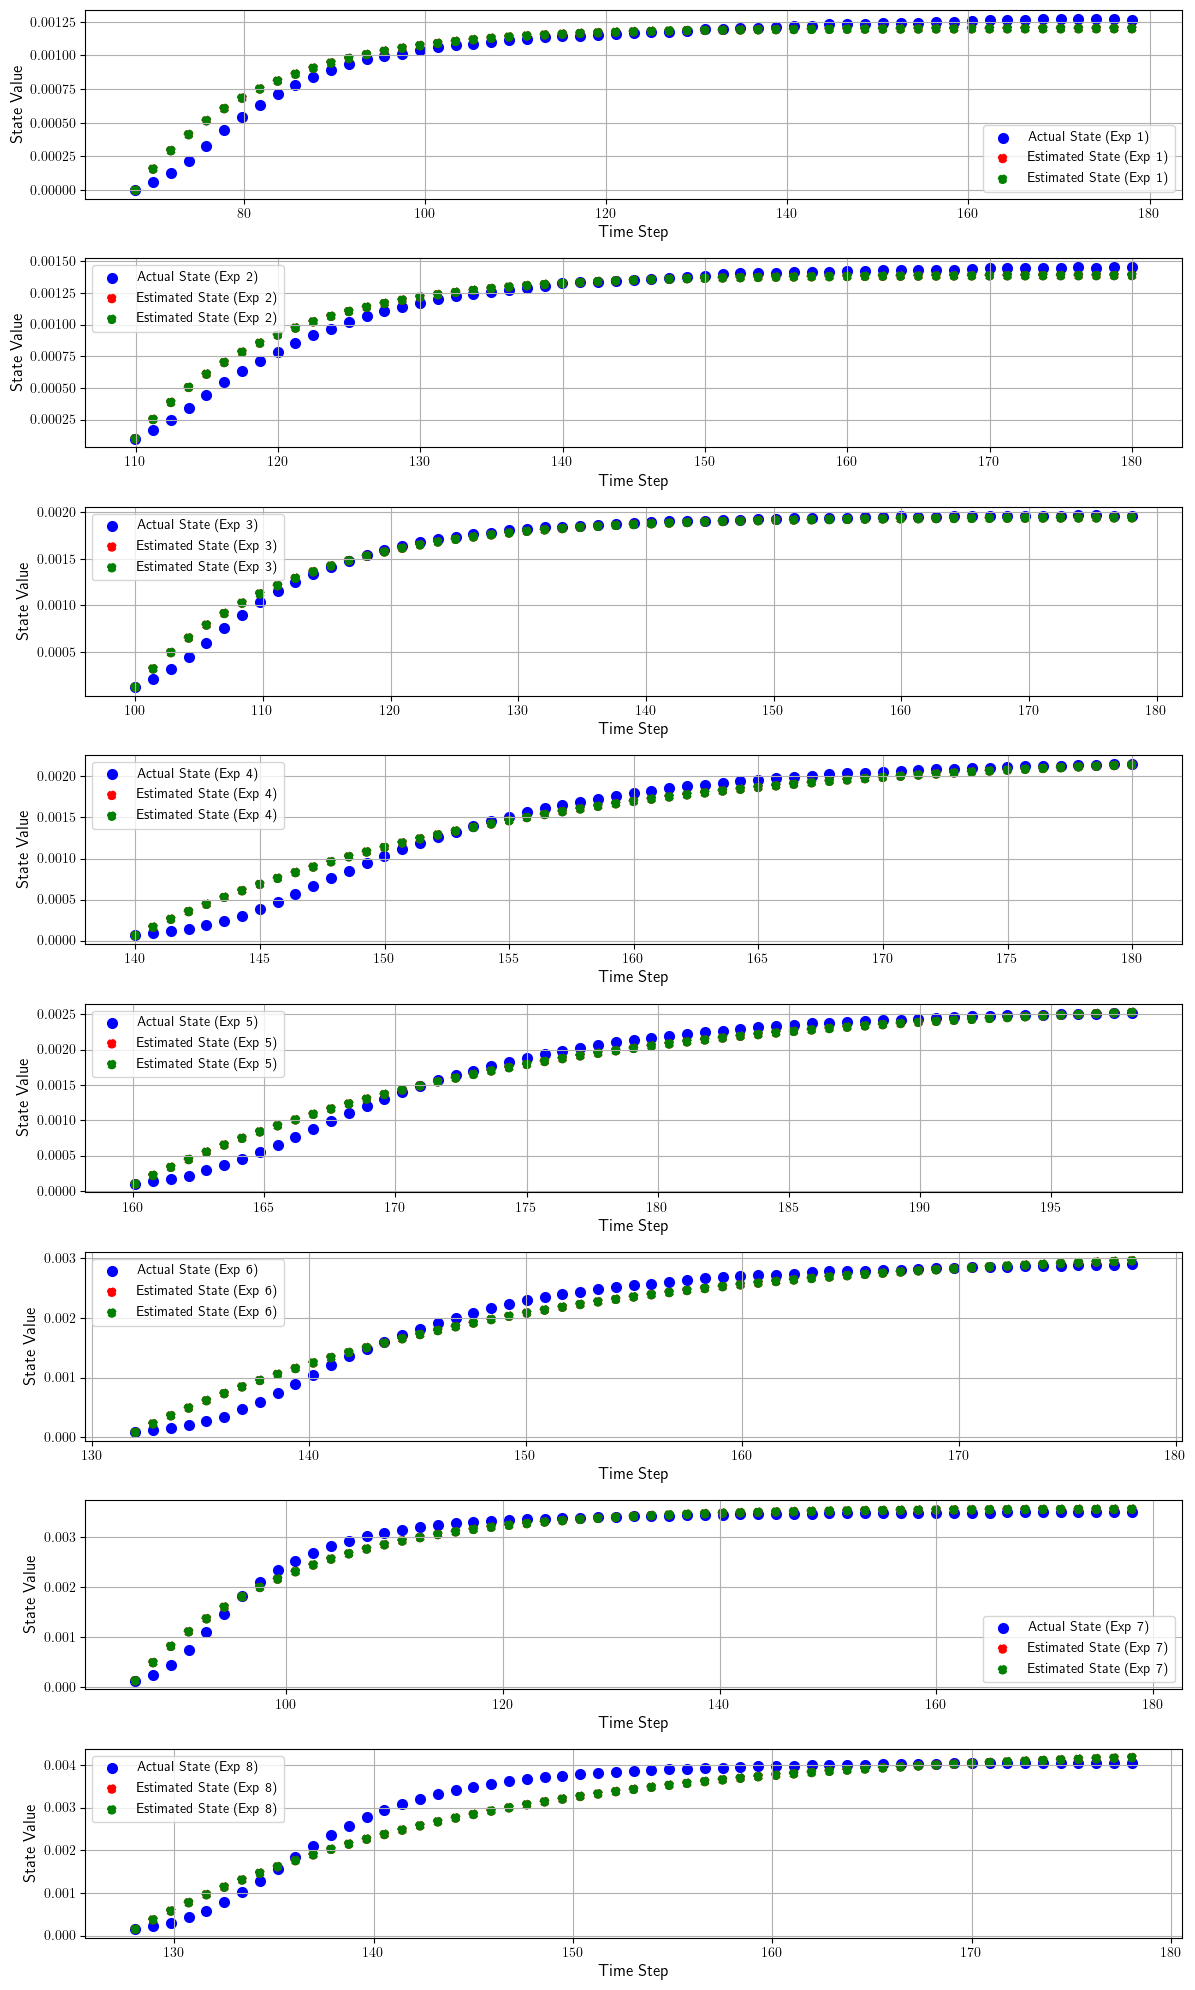

In [22]:
# Estimate the state (y_hat) for all experiments
y_hat_list = []
y_hat_list_2 = []
for exp_idx in range(n_experiments):
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt,dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka/final_kd
    u = u_list[exp_idx]
    n_points = len(y_list[exp_idx])
    y_hat = np.zeros(n_points)  # Initialize estimated state
    y_hat[0] = y_list[exp_idx][0]  # Match initial condition
    y_hat_2 = np.zeros(n_points)  # Initialize estimated state
    y_hat_2[0] = y_list[exp_idx][0]  # Match initial condition
    
    for k in range(1, n_points):
        y_hat[k] = y_hat[k - 1] + dt[k] * (final_ka * u[k - 1] * (final_theta_inf - y_hat[k - 1]) - final_kd * y_hat[k - 1])
    
    y_hat_list.append(y_hat)
    N_max = (np.array(y)[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)
    print('ka',final_ka*N_max,'kd',final_kd*N_max,'thetainf',final_theta_inf/N_max,'KA', final_ka/final_kd, 'Nmax', N_max)
    for k in range(1, n_points):
        y_hat_2[k] = y_hat_2[k - 1] + dt[k] * (final_ka*N_max * u[k - 1] * (final_theta_inf/N_max - y_hat_2[k - 1]/N_max) - final_kd*N_max * y_hat_2[k - 1]/N_max)
    y_hat_list_2.append(y_hat_2)
    # Prepare content for saving
    # results = [
    #     f"Time Values: {new_t_values[exp_idx].tolist()}",
    #     f"Actual State (y): {y.tolist()}",
    #     f"Estimated State (y_hat): {y_hat.tolist()}",
    #     f"Final Parameters:",
    #     f"  ka: {final_ka * N_max}",
    #     f"  kd: {final_kd * N_max}",
    #     f"  theta_inf: {final_theta_inf}",
    #     f"  KA: {final_ka / final_kd}",
    #     f"  Nmax: {N_max}"
    # ]

    # # Save results to a .txt file
    # filename = f"experiment_PBS_{exp_idx + 1}_results.txt"
    # with open(filename, "w") as file:
    #     file.write("\n".join(results))

    # print(f"Results saved to {filename}")
# Plot the actual vs estimated states for all experiments
plt.figure(figsize=(12, 20))

for exp_idx in range(n_experiments):
    n_points = len(y_list[exp_idx])
    plt.subplot(n_experiments, 1, exp_idx + 1)
    plt.scatter(new_t_values[exp_idx], y_list[exp_idx], label=f"Actual State (Exp {exp_idx + 1})", color='b', linewidth=2)
    plt.scatter(new_t_values[exp_idx], y_hat_list[exp_idx], label=f"Estimated State (Exp {exp_idx + 1})", color='r', linestyle='--', linewidth=1)
    plt.scatter(new_t_values[exp_idx], y_hat_list_2[exp_idx], label=f"Estimated State (Exp {exp_idx + 1})", color='g', linestyle='--', linewidth=1)
    plt.xlabel("Time Step")
    plt.ylabel("State Value")
    #plt.title(f"Experiment {exp_idx + 1}: Actual vs Estimated State")
    plt.legend(loc='best')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
np.mean(np.abs(y_hat_list_2[0]-y_hat_list[0])),np.mean(np.abs(y_hat_list_2[1]-y_hat_list[1])),np.mean(np.abs(y_hat_list_2[2]-y_hat_list[2])),np.mean(np.abs(y_hat_list_2[3]-y_hat_list[3]))

(1.8878432564769529e-19,
 6.562276307149106e-20,
 2.282530889443167e-20,
 1.1555312627806035e-19)

ka 0.5367017317811552 kd 0.0688999043001455 thetainf 0.04982168362327902 KA 7.789586026754783 Nmax 1.0551785240073601 LS 1.3392158205673444e-07
ka 0.8361861875795313 kd 0.09558083429328454 thetainf 0.03927273617607375 KA 8.748471320241253 Nmax 1.046716038871782 LS 1.43260473231438e-07
ka 0.7217566417962231 kd 0.07426884075537626 thetainf 0.04172645225094515 KA 9.718162212515425 Nmax 1.0071455176117994 LS 1.0100028299906449e-07


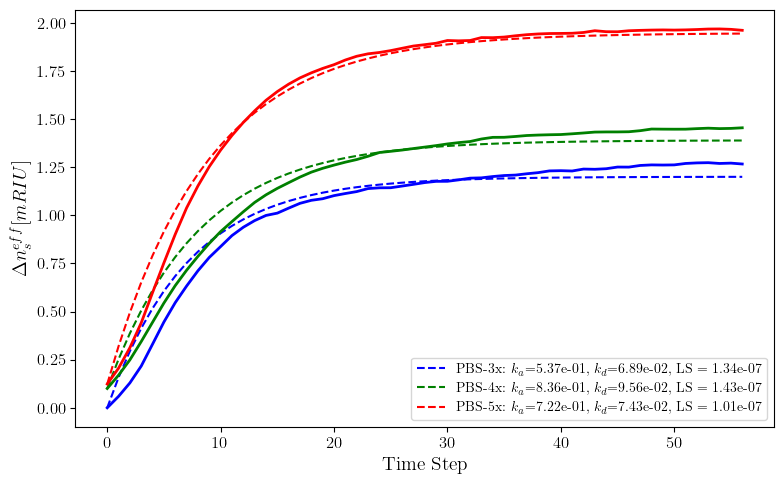

In [24]:
# Estimate the state (y_hat) for all experiments
y_hat_list = []
for exp_idx in range(n_experiments):
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt,dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka/final_kd
    u = u_list[exp_idx]
    n_points = len(y_list[exp_idx])
    y_hat = np.zeros(n_points)  # Initialize estimated state
    y_hat[0] = y_list[exp_idx][0]  # Match initial condition
    
    for k in range(1, n_points):
        y_hat[k] = y_hat[k - 1] + dt[k] * (final_ka * u[k - 1] * (final_theta_inf - y_hat[k - 1]) - final_kd * y_hat[k - 1])
    
    y_hat_list.append(y_hat)
    N_max = (y_hat[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)
    #print('ka',final_ka*N_max,'kd',final_kd*N_max,'thetainf',final_theta_inf,'KA', final_ka/final_kd, 'Nmax', N_max)
#plt.rc('font', family='Times New Roman', size=14)  # Use Times New Roman font
plt.rc('axes', titlesize=14)                      # Title font size
plt.rc('axes', labelsize=14)                      # Label font size
plt.rc('xtick', labelsize=12)                     # X-tick font size
plt.rc('ytick', labelsize=12)                     # Y-tick font size
plt.rc('legend', fontsize=12)                     # Legend font size
#plt.rc('font', family='serif', size=12)  # Use the default serif font

# Define a list of colors for each experiment
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'cyan']  # Extend if needed
plt.rc('font', family='Times New Roman', size=12)  # Use the default serif font
# Create the plot
plt.figure(figsize=(8, 5))  # Square figure size

for exp_idx in [0,1,2]:
    color = colors[exp_idx % len(colors)]  # Cycle colors if needed
    n_points = len(y_list[exp_idx])
    final_ka = ka_final_list[exp_idx]
    final_kd = kd_final_list[exp_idx]
    final_theta_inf = theta_inf_final_list[exp_idx]
    dt = dt_list[exp_idx]
    dt = np.append(dt, dt[-1])
    y = y_list[exp_idx]
    K_a = final_ka / final_kd
    u = u_list[exp_idx]
    y_hat = y_hat_list[exp_idx]
    N_max = (np.array(y)[-1] * (u[-1] + 1 / K_a)) / (u[-1] * final_theta_inf)
    MSE_value = (1/2)*np.sum((y_hat-y)**2)
    print('ka',final_ka*N_max,'kd',final_kd*N_max,'thetainf',final_theta_inf/N_max,'KA', final_ka/final_kd, 'Nmax', N_max, 'LS', MSE_value)

    
    # Format constants for the legend
    legend_label = (f"PBS-{exp_idx + 3}x:"
                    f" $k_a$={final_ka * N_max:.2e}, "
                    f" $k_d$={final_kd * N_max:.2e},"
                    f" LS = {MSE_value:.2e}")
    # Plot actual state
    plt.plot(
        range(n_points), y_list[exp_idx]*1e3,
        #label=f"Actual State (Exp {exp_idx + 1})", 
        color=color, linewidth=2
    )

    # Plot estimated state
    plt.plot(
        range(n_points), y_hat_list[exp_idx]*1e3,
        label=legend_label, 
        color=color, linestyle='--', linewidth=1.5
    )

# Configure axis labels, legend, and grid
plt.xlabel("Time Step")
plt.ylabel(r'$\Delta n_s^{eff} [mRIU]$')
plt.legend(loc='best',fontsize = 10)
plt.grid(False)

# Ensure square plot
plt.gca().set_aspect('auto', adjustable='box')

# Display the plot
plt.tight_layout()
plt.savefig("estimated_state_PBS.png", dpi=300)
plt.show()